# Machine Learning

Anggota Kelompok :

1. Haidar Dimas Heryanto - 2022210370311088
2. Alfi Aulia Azzahra - 202210370311095

# PART 1: KLASIK ML

## INSTALL & IMPORT LIBRARIES

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q roboflow albumentations opencv-python scikit-learn scikit-image matplotlib seaborn imbalanced-learn

import os
import shutil
import cv2
import yaml
import numpy as np
import pandas as pd
import random
import albumentations as A
from roboflow import Roboflow
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
from collections import Counter

print("✅ Libraries imported successfully!")

def set_all_seeds(seed=42):
    """Set all random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"\n🎲 All random seeds set to: {seed}")


set_all_seeds(42)

✅ Libraries imported successfully!

🎲 All random seeds set to: 42


## LOAD DATASET DARI ROBOFLOW

In [ ]:
rf = Roboflow(api_key="9J11qljgG9odzZnvoVbg")
project = rf.workspace("aa-cqfub").project("h3lm-40l0-oid-xd-3dofr")
version = project.version(5)
dataset = version.download("yolov11")

# Target classes (pakai 2 label saja)
TARGET_CLASSES = {1: 0, 5: 1}  # 1=no_helmet→0, 5=with_helmet→1
CLASS_NAMES = ['no_helmet', 'with_helmet']

print(f"\n✅ Dataset downloaded!")
print(f"📁 Location: {dataset.location}")
print(f"🎯 Target Classes: {CLASS_NAMES}")

loading Roboflow workspace...
loading Roboflow project...

✅ Dataset downloaded!
📁 Location: /content/h3Lm-40L0-Oid-XD-5
🎯 Target Classes: ['no_helmet', 'with_helmet']


## PREPROCESSING & AUGMENTASI

In [ ]:
transform_crop = A.Compose([
    A.Resize(128, 128),
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=20, p=0.5),
])

print("\n✅ Augmentation pipeline configured:")
print("   • Resize: 128x128")
print("   • Gaussian Blur")
print("   • Horizontal Flip")
print("   • Rotation ±15°")
print("   • Brightness/Contrast adjustment")
print("   • HSV color shift")


✅ Augmentation pipeline configured:
   • Resize: 128x128
   • Gaussian Blur
   • Horizontal Flip
   • Rotation ±15°
   • Brightness/Contrast adjustment
   • HSV color shift


### HELPER FUNCTIONS

In [ ]:
# @title
def yolo_to_bbox(x_center, y_center, width, height, img_width, img_height):
    """Convert YOLO format to pixel coordinates"""
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    x1 = int(max(0, x_center - width / 2))
    y1 = int(max(0, y_center - height / 2))
    x2 = int(min(img_width, x_center + width / 2))
    y2 = int(min(img_height, y_center + height / 2))

    return x1, y1, x2, y2


def load_cropped_data(dataset_path):
    """
    Load and crop bboxes WITHOUT augmentation
    Augmentation will be applied later ONLY to training set
    """
    print("\n📦 Loading and cropping bboxes...")

    all_images = []
    all_labels = []
    total_bboxes = 0

    for split in ['train', 'valid', 'test']:
        img_folder = os.path.join(dataset_path, split, "images")
        label_folder = os.path.join(dataset_path, split, "labels")

        if not os.path.exists(img_folder):
            continue

        image_files = sorted([f for f in os.listdir(img_folder)
                             if f.endswith(('.jpg', '.png'))])

        for img_file in image_files:
            img_path = os.path.join(img_folder, img_file)
            label_path = os.path.join(label_folder,
                                     img_file.replace('.jpg', '.txt').replace('.png', '.txt'))

            image = cv2.imread(img_path)
            if image is None:
                continue

            img_height, img_width = image.shape[:2]
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            if not os.path.exists(label_path):
                continue

            with open(label_path, 'r') as f:
                lines = f.readlines()
                lines = sorted(lines)

                for line in lines:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        cls = int(parts[0])

                        if cls not in TARGET_CLASSES:
                            continue

                        x_c, y_c, w, h = map(float, parts[1:])
                        x1, y1, x2, y2 = yolo_to_bbox(x_c, y_c, w, h, img_width, img_height)

                        if (x2 - x1) < 10 or (y2 - y1) < 10:
                            continue

                        cropped = image_rgb[y1:y2, x1:x2]
                        if cropped.size == 0:
                            continue

                        try:
                            # Only resize - NO augmentation yet
                            resized = cv2.resize(cropped, (128, 128))
                            resized_bgr = cv2.cvtColor(resized, cv2.COLOR_RGB2BGR)

                            all_images.append(resized_bgr)
                            all_labels.append(TARGET_CLASSES[cls])
                            total_bboxes += 1
                        except:
                            continue

    print(f"✅ Processed: {total_bboxes} bboxes")
    print(f"   Distribution: {np.bincount(all_labels).tolist()} (0=no_helmet, 1=with_helmet)")

    return all_images, np.array(all_labels)


def augment_training_data(X_train, y_train, augmentation_seed=42, target_balance_ratio=1.0):
    """
    Apply CLASS-SPECIFIC augmentation to balance dataset

    Parameters:
    -----------
    X_train : array
        Training images
    y_train : array
        Training labels
    augmentation_seed : int
        Random seed for reproducibility
    target_balance_ratio : float
        Target ratio between classes (1.0 = perfect balance)

    Returns:
    --------
    X_aug, y_aug : Augmented and balanced dataset
    """

    print(f"\n🔄 Applying class-specific augmentation...")
    print(f"   Original training size: {len(X_train)}")
    print(f"   Original distribution: {np.bincount(y_train).tolist()}")

    # Set seed ONCE at the beginning
    random.seed(augmentation_seed)
    np.random.seed(augmentation_seed)

    # Separate by class
    class_counts = np.bincount(y_train)
    majority_count = max(class_counts)

    X_augmented = []
    y_augmented = []

    for cls in range(len(class_counts)):
        cls_indices = np.where(y_train == cls)[0]
        cls_images = X_train[cls_indices]

        # Calculate target count
        current_count = len(cls_images)
        target_count = int(majority_count * target_balance_ratio)

        # Add original images
        X_augmented.extend(cls_images)
        y_augmented.extend([cls] * len(cls_images))

        # Calculate how many augmentations needed
        n_augmentations_needed = max(0, target_count - current_count)

        if n_augmentations_needed > 0:
            print(f"   Class {cls} ({CLASS_NAMES[cls]}): {current_count} → {target_count} samples")
            print(f"      Generating {n_augmentations_needed} augmented samples...")

            # Generate augmentations
            for _ in range(n_augmentations_needed):
                # Randomly select image from this class
                idx = np.random.randint(0, len(cls_images))
                img = cls_images[idx]

                try:
                    # Convert BGR to RGB
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    # Apply augmentation
                    aug = transform_crop(image=img_rgb)
                    aug_img = np.clip(aug['image'], 0, 255).astype(np.uint8)
                    aug_img_bgr = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)

                    X_augmented.append(aug_img_bgr)
                    y_augmented.append(cls)

                except Exception as e:
                    print(f"⚠️ Augmentation failed: {e}")
                    continue

    X_train_aug = np.array(X_augmented)
    y_train_aug = np.array(y_augmented)

    # Shuffle with seed
    shuffle_idx = np.arange(len(X_train_aug))
    np.random.shuffle(shuffle_idx)
    X_train_aug = X_train_aug[shuffle_idx]
    y_train_aug = y_train_aug[shuffle_idx]

    print(f"\n   ✅ After augmentation: {len(X_train_aug)} samples")
    print(f"   Final distribution: {np.bincount(y_train_aug).tolist()}")

    return X_train_aug, y_train_aug


def run_experiment(X, y, feature_name, algorithms_dict,
                   feature_extractor=None,
                   apply_augmentation=False,
                   augmentation_seed=42,
                   show_plots=True):
    """
    Universal experiment runner (WITHOUT CROSS-VALIDATION)

    Parameters:
    -----------
    X : array-like
        Raw images or pre-extracted features
    y : array-like
        Labels
    feature_name : str
        Name of feature set
    algorithms_dict : dict
        Dictionary of algorithms to test
    feature_extractor : function, optional
        Feature extraction function (None if X is already features)
    apply_augmentation : bool
        If True, augment training images
    augmentation_seed : int
        Seed for augmentation
    show_plots : bool
        Whether to show plots

    Returns:
    --------
    results : list
        List of result dictionaries
    best : dict
        Best model result
    """

    print(f"🧪 RUNNING EXPERIMENTS: {feature_name}")


    results = []
    is_image_mode = feature_extractor is not None

    if is_image_mode:
        print(f"📸 Mode: RAW IMAGES → will extract features per-split")
    else:
        print(f"📊 Mode: PRE-EXTRACTED FEATURES")

    # Convert to numpy
    X = np.array(X)
    y = np.array(y)

    # Split data: 80% train, 10% val, 10% test
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    print(f"\n📊 Data Split:")
    print(f"   Train: {len(y_train)} samples - {np.bincount(y_train).tolist()}")
    print(f"   Val:   {len(y_val)} samples - {np.bincount(y_val).tolist()}")
    print(f"   Test:  {len(y_test)} samples - {np.bincount(y_test).tolist()}")

    # Augmentation + Feature extraction (if image mode)
    if is_image_mode:
        if apply_augmentation:
            print(f"\n🔄 Augmenting training images...")
            try:
                X_train, y_train = augment_training_data(
                    X_train, y_train,
                    augmentation_seed,
                    target_balance_ratio=1.0
                )
            except Exception as e:
                print(f"⚠️ Augmentation failed: {e}")
                print(f"   Continuing with original training data...")

        # Extract features
        print(f"\n📊 Extracting features...")
        print(f"   Train: {len(X_train)} images")
        X_train = np.array([feature_extractor(img) for img in X_train])

        print(f"   Val: {len(X_val)} images")
        X_val = np.array([feature_extractor(img) for img in X_val])

        print(f"   Test: {len(X_test)} images")
        X_test = np.array([feature_extractor(img) for img in X_test])

        print(f"✅ Features extracted: Train={X_train.shape}, Val={X_val.shape}, Test={X_test.shape}")

    # SMOTE for class imbalance
    class_counts = np.bincount(y_train)
    min_class_count = min(class_counts)
    imbalance_ratio = max(class_counts) / min_class_count

    print(f"\n⚖️ Class balance check:")
    print(f"   Distribution: {class_counts.tolist()}")
    print(f"   Imbalance ratio: {imbalance_ratio:.2f}:1")

    if imbalance_ratio > 1.5 and min_class_count >= 6:
        k_neighbors = min(5, min_class_count - 1)

        try:
            smote = SMOTE(
                random_state=42,
                k_neighbors=k_neighbors,
                sampling_strategy='auto'
            )
            X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
            print(f"   ✅ SMOTE applied: {class_counts.tolist()} → {np.bincount(y_train_bal).tolist()}")

        except Exception as e:
            print(f"   ⚠️ SMOTE failed: {e}, using original data")
            X_train_bal, y_train_bal = X_train, y_train

    elif min_class_count < 6:
        print(f"   ⚠️ SMOTE skipped: minority class too small ({min_class_count} < 6)")
        X_train_bal, y_train_bal = X_train, y_train
    else:
        print(f"   ℹ️ Classes relatively balanced, SMOTE not needed")
        X_train_bal, y_train_bal = X_train, y_train

    # Normalize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_bal)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # PCA
    print(f"\n📉 PCA dimensionality reduction:")
    print(f"   Original features: {X_train_scaled.shape[1]}")

    pca = PCA(n_components=0.95, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_pca = pca.transform(X_val_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    actual_variance = np.sum(pca.explained_variance_ratio_)
    print(f"   Components: {X_train_pca.shape[1]}")
    print(f"   Variance retained: {actual_variance:.4f}")
    print(f"   Compression: {X_train_scaled.shape[1] / X_train_pca.shape[1]:.2f}x")

    # Train & evaluate algorithms
    for algo_name, algorithm in algorithms_dict.items():
        print(f"\n  🔹 Training {algo_name}...")

        start = time.time()
        algorithm.fit(X_train_pca, y_train_bal)
        train_time = time.time() - start

        train_acc = accuracy_score(y_train_bal, algorithm.predict(X_train_pca))
        val_acc = accuracy_score(y_val, algorithm.predict(X_val_pca))
        test_acc = accuracy_score(y_test, algorithm.predict(X_test_pca))

        print(f"     Train: {train_acc:.4f} | Val: {val_acc:.4f} | Test: {test_acc:.4f} | Time: {train_time:.2f}s")

        # Predictions
        y_pred = algorithm.predict(X_test_pca)

        # Calculate metrics
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

        results.append({
            'algorithm': algo_name,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'test_acc': test_acc,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'overfitting': train_acc - test_acc,
            'train_time': train_time,
            'model': algorithm,
            'scaler': scaler,
            'pca': pca,
            'y_test': y_test,
            'y_pred': y_pred
        })

    # Find best model
    best = max(results, key=lambda x: x['test_acc'])

    # Visualizations
    if show_plots:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Confusion matrix
        cm = confusion_matrix(best['y_test'], best['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[0])
        axes[0].set_title(f"{feature_name}\nBest: {best['algorithm']} - Acc: {best['test_acc']:.2%}",
                         fontweight='bold')
        axes[0].set_ylabel('True Label')
        axes[0].set_xlabel('Predicted Label')

        # Bar comparison
        test_accs = [r['test_acc'] for r in results]
        algo_names = [r['algorithm'] for r in results]
        colors = ['#6bcf7f' if acc == max(test_accs) else '#ffd93d' if acc > 0.75 else '#ff6b6b'
                 for acc in test_accs]

        axes[1].barh(algo_names, test_accs, color=colors, edgecolor='black')
        axes[1].set_xlabel('Test Accuracy')
        axes[1].set_title(f'{feature_name} - Algorithms Comparison', fontweight='bold')
        axes[1].axvline(x=0.75, color='red', linestyle='--', alpha=0.5, label='75%')
        axes[1].legend()
        axes[1].grid(axis='x', alpha=0.3)

        for i, v in enumerate(test_accs):
            axes[1].text(v + 0.01, i, f'{v:.1%}', va='center', fontweight='bold')

        plt.tight_layout()
        plt.savefig(f"{feature_name.lower().replace(' ', '_').replace(':', '')}_results.png",
                   dpi=300, bbox_inches='tight')
        print(f"\n✅ Plot saved")
        plt.show()

        # Classification report
        print(f"\n📋 Classification Report - Best Model ({best['algorithm']}):")
        print(classification_report(best['y_test'], best['y_pred'],
                                   target_names=CLASS_NAMES, zero_division=0))

    return results, best


def save_best_model(best_result, set_name, feature_extractor_func, save_path):
    """Save best model for each feature set"""
    filename = f"best_model_{set_name.lower().replace(' ', '_').replace(':', '')}.pkl"
    filepath = os.path.join(save_path, filename)

    with open(filepath, 'wb') as f:
        pickle.dump({
            'model': best_result['model'],
            'scaler': best_result['scaler'],
            'pca': best_result['pca'],
            'feature_set': set_name,
            'algorithm': best_result['algorithm'],
            'feature_extractor': feature_extractor_func,
            'class_names': CLASS_NAMES,
            'test_acc': best_result['test_acc'],
            'val_acc': best_result['val_acc'],
            'train_acc': best_result['train_acc'],
            'precision': best_result['precision'],
            'recall': best_result['recall'],
            'f1_score': best_result['f1_score'],
            'overfitting': best_result['overfitting']
        }, f)

    print(f"✅ Model saved: {filename}")
    return filepath

def extract_set1_features(image):
    """Feature Set 1: Histogram + HOG + LBP"""
    # Histogram (Color Distribution)
    hist_features = []
    for i in range(3):
        hist = cv2.calcHist([image], [i], None, [32], [0, 256])
        hist = hist.flatten() / (hist.sum() + 1e-7)
        hist_features.extend(hist)

    # HOG (Shape/Edge)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog_feat = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), block_norm='L2-Hys',
                   visualize=False, feature_vector=True)

    # LBP (Texture)
    lbp = local_binary_pattern(gray, 24, 3, method='uniform')
    n_bins = int(lbp.max() + 1)
    lbp_hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins), density=True)

    return np.concatenate([hist_features, hog_feat, lbp_hist])


def extract_set2_features(image):
    """Feature Set 2: Color Moments + HOG + GLCM"""
    features = []

    # Color Moments (Mean, Std, Skewness)
    for i in range(3):
        channel = image[:,:,i].astype(np.float64)
        mean_val = np.mean(channel)
        std_val = np.std(channel)
        centered = channel - mean_val
        skew_val = np.mean(centered**3) / (std_val**3 + 1e-7)
        features.extend([mean_val, std_val, skew_val])

    # HOG (optimized)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog_feat = hog(gray, orientations=9, pixels_per_cell=(16, 16),
                   cells_per_block=(2, 2), block_norm='L2-Hys',
                   visualize=False, feature_vector=True)

    # GLCM (Texture)
    gray_norm = (gray / 16).astype(np.uint8)
    glcm = graycomatrix(gray_norm, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        levels=16, symmetric=True, normed=True)

    glcm_features = []
    for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']:
        glcm_features.extend(graycoprops(glcm, prop).flatten())

    return np.concatenate([features, hog_feat, glcm_features])


def extract_set3_features(image):
    """Feature Set 3: Edge + HOG + Color Histogram"""
    features = []
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Edge Features (Canny + Sobel)
    edges_canny = cv2.Canny(gray, 50, 150)
    features.extend([
        np.sum(edges_canny > 0) / edges_canny.size,
        np.mean(edges_canny),
        np.std(edges_canny)
    ])

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    features.extend([np.mean(np.abs(sobelx)), np.mean(np.abs(sobely))])

    # HOG (compact)
    hog_feat = hog(gray, orientations=8, pixels_per_cell=(16, 16),
                   cells_per_block=(2, 2), block_norm='L2-Hys',
                   visualize=False, feature_vector=True)

    # Color Histogram (reduced)
    hist_features = []
    for i in range(3):
        hist = cv2.calcHist([image], [i], None, [16], [0, 256])
        hist = hist.flatten() / (hist.sum() + 1e-7)
        hist_features.extend(hist)

    return np.concatenate([features, hog_feat, hist_features])


algorithms = {
    'SVM-RBF': SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=42),
    'SVM-Linear': SVC(kernel='linear', C=0.5, class_weight='balanced', random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
}


drive_save_path = "/content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab"
os.makedirs(drive_save_path, exist_ok=True)

print(f"\n✅ Save path: {drive_save_path}")


✅ Save path: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab


### CROP BBOXES (MULTIPLE LABELS)

> pada sebuah citra jika terdapat 2 label, perlabel akan di crop dan dijadikan citra baru. agar menyesuaikan jumlah label yg ada di roboflow (kuliat sama sih jumlahe). dan semua label terbaca walaupun dalam satu citra terdapat multilabel

In [ ]:
cropped_images, labels = load_cropped_data(dataset.location)

print(f"\n✅ Total cropped bboxes: {len(cropped_images)}")
assert len(cropped_images) == len(labels), f"Mismatch! Images: {len(cropped_images)}, Labels: {len(labels)}"



📦 Loading and cropping bboxes...
✅ Processed: 1334 bboxes
   Distribution: [832, 502] (0=no_helmet, 1=with_helmet)

✅ Total cropped bboxes: 1334


> no_helmet	= 837 || with_helmet	= 502

ini dari jumlah label yg ada di roboflow (beda dikit ternyata, kayanya bisa jadi gara-gara label e terlalu kecil)

#### Contoh hasil crop



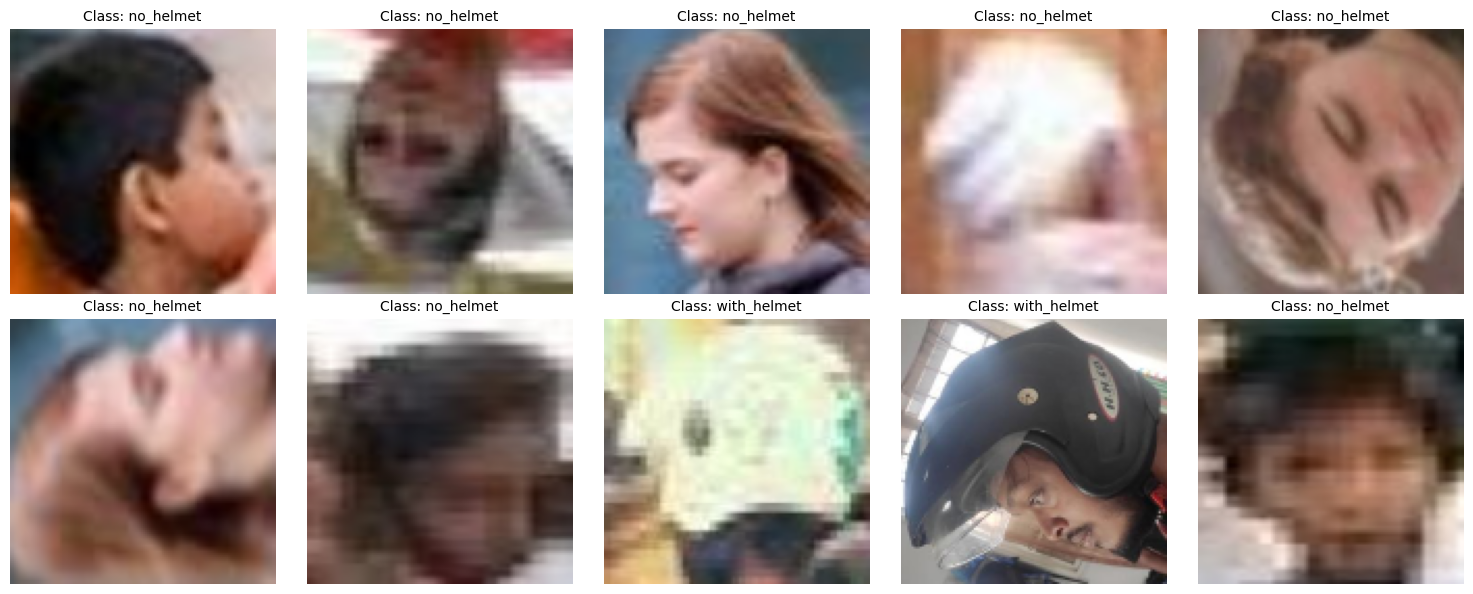

In [ ]:
# @title
num_examples = 10
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

# Get class names from the loaded dataset config or define them
# Assuming CLASS_NAMES is already defined as ['no_helmet', 'with_helmet']
# If not, uncomment the following lines to load from data.yaml
# original_yaml = os.path.join(dataset.location, "data.yaml")
# with open(original_yaml, 'r') as f:
#     data_config = yaml.safe_load(f)
# CLASS_NAMES = data_config['names'] # Make sure this matches your TARGET_CLASSES mapping


# Select random indices
random_indices = np.random.choice(len(cropped_images), num_examples, replace=False)

for i, idx in enumerate(random_indices):
    img = cropped_images[idx]
    label = labels[idx]
    class_name = CLASS_NAMES[label]

    axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[i].set_title(f"Class: {class_name}", fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## Future Extraction

Terdapat 3 set eksperimen. per set masing-masing menerapkan 3 filter klasik dan 4 algoritma




###  SET 1: HISTOGRAM + HOG + LBP

EXPERIMENT SET 1: HISTOGRAM + HOG + LBP
🧪 RUNNING EXPERIMENTS: SET 1: Histogram+HOG+LBP
📸 Mode: RAW IMAGES → will extract features per-split

📊 Data Split:
   Train: 1067 samples - [665, 402]
   Val:   133 samples - [83, 50]
   Test:  134 samples - [84, 50]

🔄 Augmenting training images...

🔄 Applying class-specific augmentation...
   Original training size: 1067
   Original distribution: [665, 402]
   Class 1 (with_helmet): 402 → 665 samples
      Generating 263 augmented samples...

   ✅ After augmentation: 1330 samples
   Final distribution: [665, 665]

📊 Extracting features...
   Train: 1330 images
   Val: 133 images
   Test: 134 images
✅ Features extracted: Train=(1330, 8222), Val=(133, 8222), Test=(134, 8222)

⚖️ Class balance check:
   Distribution: [665, 665]
   Imbalance ratio: 1.00:1
   ℹ️ Classes relatively balanced, SMOTE not needed

📉 PCA dimensionality reduction:
   Original features: 8222
   Components: 844
   Variance retained: 0.9501
   Compression: 9.74x

  🔹 Training

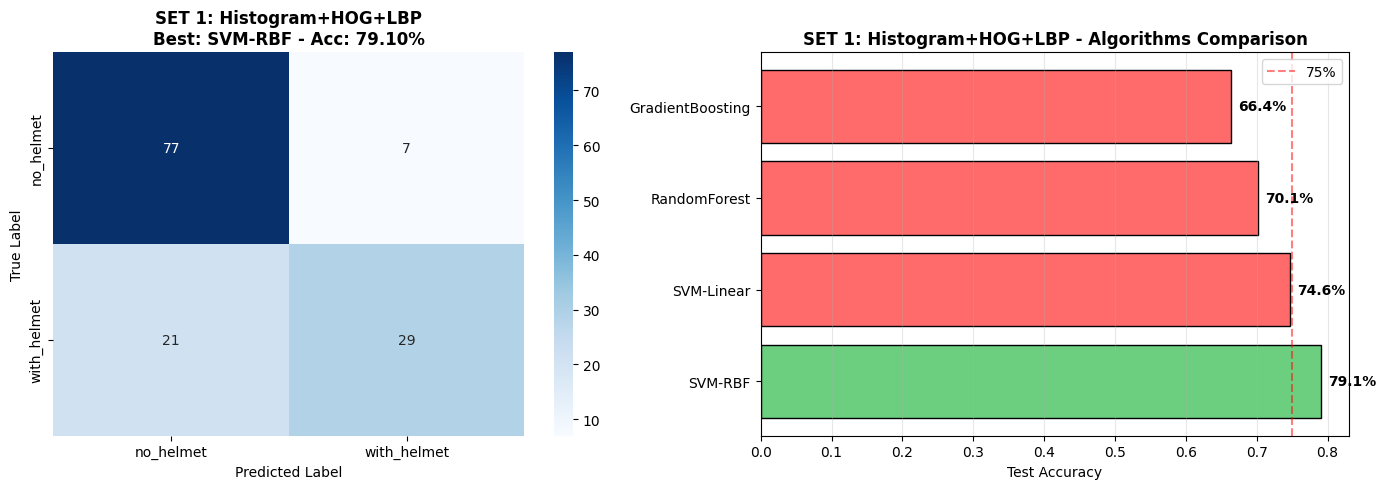


📋 Classification Report - Best Model (SVM-RBF):
              precision    recall  f1-score   support

   no_helmet       0.79      0.92      0.85        84
 with_helmet       0.81      0.58      0.67        50

    accuracy                           0.79       134
   macro avg       0.80      0.75      0.76       134
weighted avg       0.79      0.79      0.78       134

✅ Model saved: best_model_set_1.pkl


In [ ]:
print("EXPERIMENT SET 1: HISTOGRAM + HOG + LBP")

results_set1, best_set1 = run_experiment(
    cropped_images,
    labels,
    "SET 1: Histogram+HOG+LBP",
    algorithms,
    feature_extractor=extract_set1_features,
    apply_augmentation=True
)

saved_file_set1 = save_best_model(best_set1, "SET 1", extract_set1_features, drive_save_path)


### SET 2: COLOR MOMENTS + HOG + GLCM

EXPERIMENT SET 2: COLOR MOMENTS + HOG + GLCM
🧪 RUNNING EXPERIMENTS: SET 2: ColorMoments+HOG+GLCM
📸 Mode: RAW IMAGES → will extract features per-split

📊 Data Split:
   Train: 1067 samples - [665, 402]
   Val:   133 samples - [83, 50]
   Test:  134 samples - [84, 50]

🔄 Augmenting training images...

🔄 Applying class-specific augmentation...
   Original training size: 1067
   Original distribution: [665, 402]
   Class 1 (with_helmet): 402 → 665 samples
      Generating 263 augmented samples...

   ✅ After augmentation: 1330 samples
   Final distribution: [665, 665]

📊 Extracting features...
   Train: 1330 images
   Val: 133 images
   Test: 134 images
✅ Features extracted: Train=(1330, 1793), Val=(133, 1793), Test=(134, 1793)

⚖️ Class balance check:
   Distribution: [665, 665]
   Imbalance ratio: 1.00:1
   ℹ️ Classes relatively balanced, SMOTE not needed

📉 PCA dimensionality reduction:
   Original features: 1793
   Components: 376
   Variance retained: 0.9501
   Compression: 4.77x

  🔹

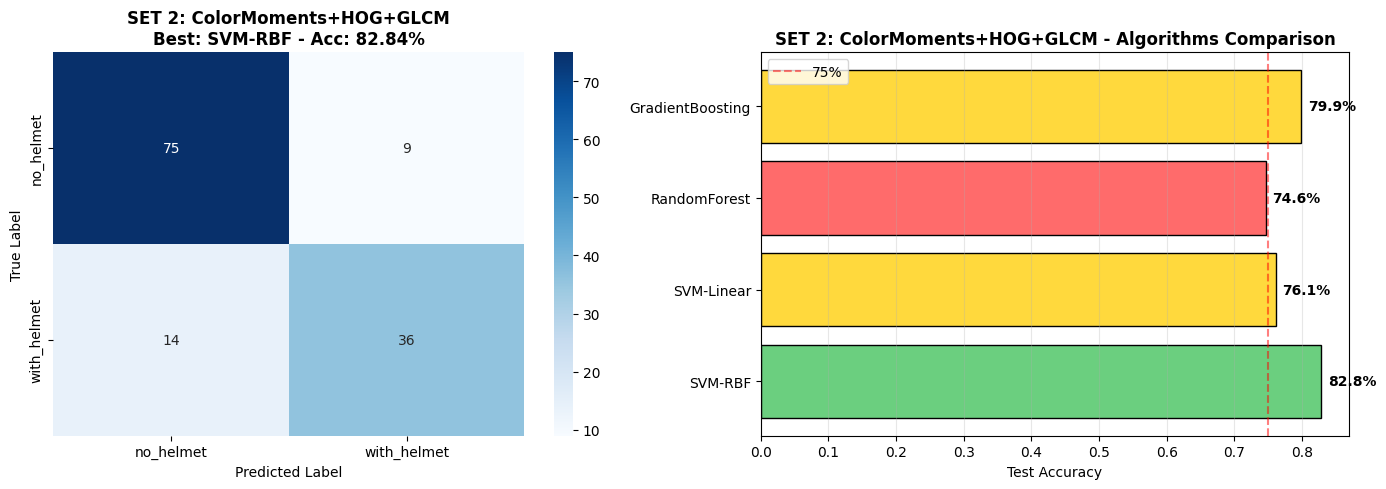


📋 Classification Report - Best Model (SVM-RBF):
              precision    recall  f1-score   support

   no_helmet       0.84      0.89      0.87        84
 with_helmet       0.80      0.72      0.76        50

    accuracy                           0.83       134
   macro avg       0.82      0.81      0.81       134
weighted avg       0.83      0.83      0.83       134

✅ Model saved: best_model_set_2.pkl


In [ ]:
print("EXPERIMENT SET 2: COLOR MOMENTS + HOG + GLCM")

results_set2, best_set2 = run_experiment(
    cropped_images,
    labels,
    "SET 2: ColorMoments+HOG+GLCM",
    algorithms,
    feature_extractor=extract_set2_features,
    apply_augmentation=True
)

saved_file_set2 = save_best_model(best_set2, "SET 2", extract_set2_features, drive_save_path)


### SET 3: EDGE + HOG + COLOR HISTOGRAM

EXPERIMENT SET 3: EDGE + HOG + COLOR HISTOGRAM
🧪 RUNNING EXPERIMENTS: SET 3: Edge+HOG+ColorHist
📸 Mode: RAW IMAGES → will extract features per-split

📊 Data Split:
   Train: 1067 samples - [665, 402]
   Val:   133 samples - [83, 50]
   Test:  134 samples - [84, 50]

🔄 Augmenting training images...

🔄 Applying class-specific augmentation...
   Original training size: 1067
   Original distribution: [665, 402]
   Class 1 (with_helmet): 402 → 665 samples
      Generating 263 augmented samples...

   ✅ After augmentation: 1330 samples
   Final distribution: [665, 665]

📊 Extracting features...
   Train: 1330 images
   Val: 133 images
   Test: 134 images
✅ Features extracted: Train=(1330, 1621), Val=(133, 1621), Test=(134, 1621)

⚖️ Class balance check:
   Distribution: [665, 665]
   Imbalance ratio: 1.00:1
   ℹ️ Classes relatively balanced, SMOTE not needed

📉 PCA dimensionality reduction:
   Original features: 1621
   Components: 359
   Variance retained: 0.9500
   Compression: 4.52x

  🔹 

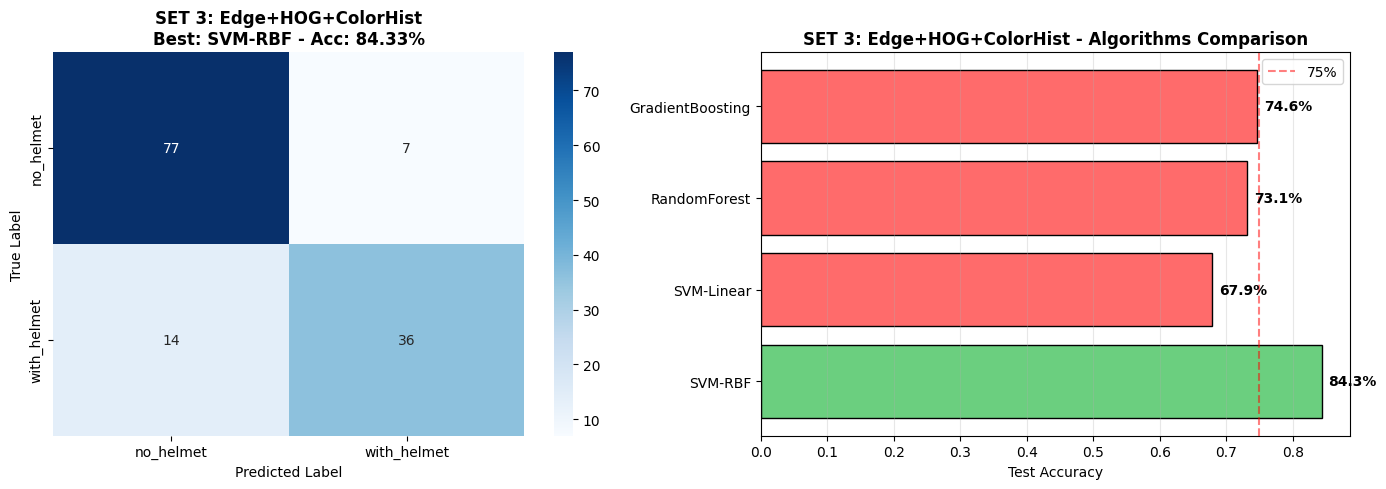


📋 Classification Report - Best Model (SVM-RBF):
              precision    recall  f1-score   support

   no_helmet       0.85      0.92      0.88        84
 with_helmet       0.84      0.72      0.77        50

    accuracy                           0.84       134
   macro avg       0.84      0.82      0.83       134
weighted avg       0.84      0.84      0.84       134

✅ Model saved: best_model_set_3.pkl


In [ ]:

print("EXPERIMENT SET 3: EDGE + HOG + COLOR HISTOGRAM")


results_set3, best_set3 = run_experiment(
    cropped_images,
    labels,
    "SET 3: Edge+HOG+ColorHist",
    algorithms,
    feature_extractor=extract_set3_features,
    apply_augmentation=True
)

saved_file_set3 = save_best_model(best_set3, "SET 3", extract_set3_features, drive_save_path)


## Perbandingan Semua Set

📊 COMPARISON OF ALL FEATURE SETS

📋 RESULTS TABLE:


,Feature Set,Algorithm,Test Acc,Val Acc,Train Acc,Precision,Recall,F1-Score,Overfitting,Time (s)
0,SET 1,SVM-RBF,79.10%,83.46%,98.95%,79.31%,79.10%,78.21%,19.84%,0.57
1,SET 1,SVM-Linear,74.63%,79.70%,100.00%,74.85%,74.63%,74.72%,25.37%,0.35
2,SET 1,RandomForest,70.15%,70.68%,100.00%,69.73%,70.15%,69.87%,29.85%,3.61
3,SET 1,GradientBoosting,66.42%,79.70%,100.00%,66.28%,66.42%,66.35%,33.58%,87.05
4,SET 2,SVM-RBF,82.84%,87.97%,98.20%,82.68%,82.84%,82.63%,15.36%,0.30
5,SET 2,SVM-Linear,76.12%,76.69%,98.65%,76.33%,76.12%,76.21%,22.53%,4.95
6,SET 2,RandomForest,74.63%,75.94%,100.00%,74.20%,74.63%,74.25%,25.37%,1.96
7,SET 2,GradientBoosting,79.85%,78.20%,100.00%,79.68%,79.85%,79.37%,20.15%,40.02
8,SET 3,SVM-RBF,84.33%,86.47%,98.57%,84.28%,84.33%,84.05%,14.24%,0.34
9,SET 3,SVM-Linear,67.91%,78.20%,97.82%,67.00%,67.91%,67.14%,29.91%,6.03



🏆 BEST OVERALL MODEL
   Feature Set: SET 3
   Algorithm: SVM-RBF
   Test Accuracy: 84.33%
   Val Accuracy: 86.47%
   Precision: 84.28%
   Recall: 84.33%
   F1-Score: 84.05%
   Overfitting: 14.24%
   Training Time: 0.34s

✅ Saved: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab/complete_analysis_all_sets.png


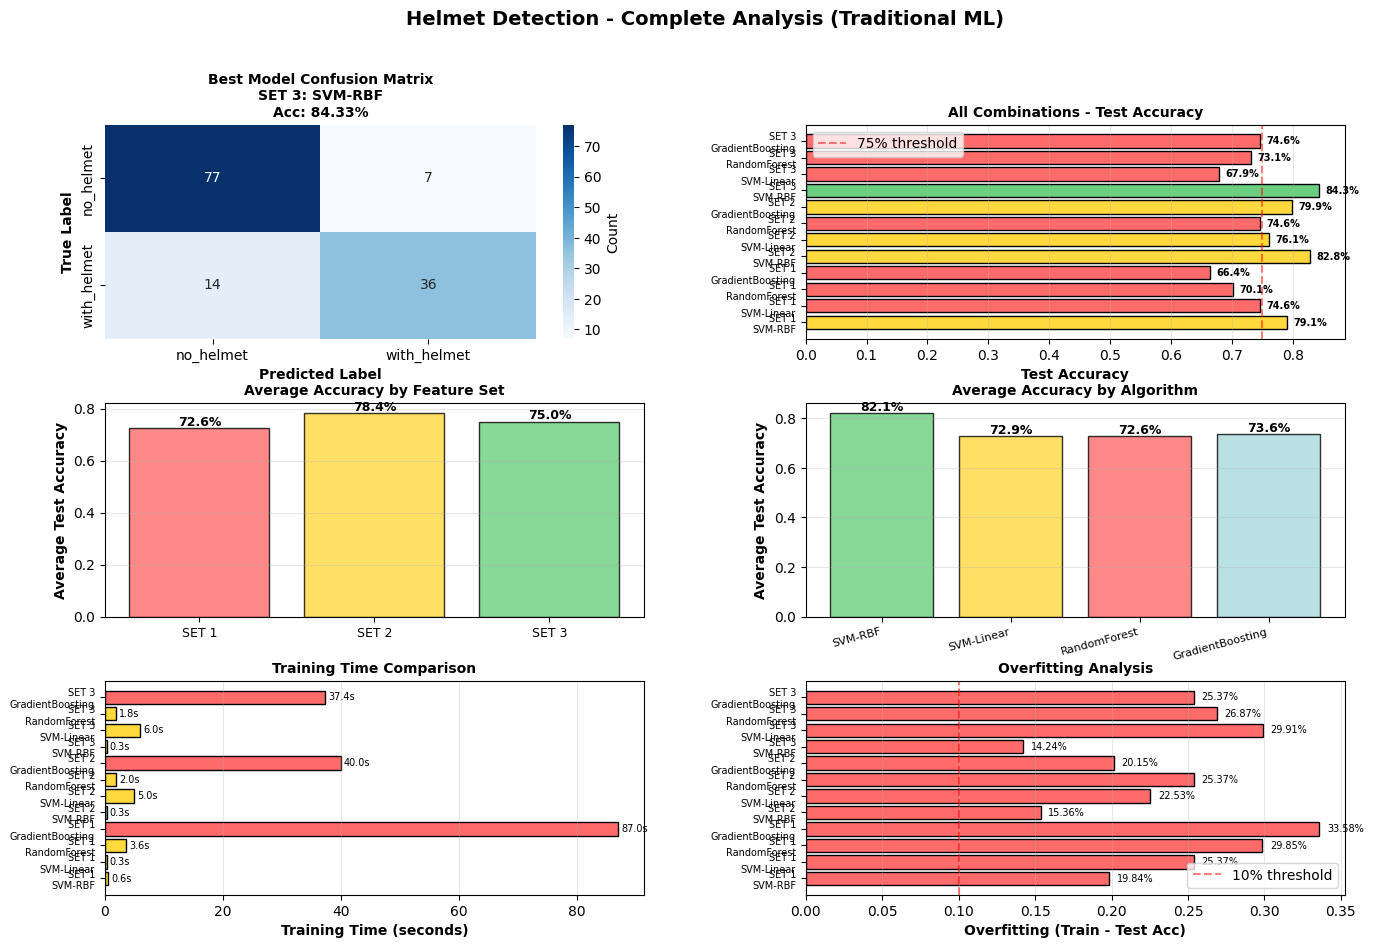

In [ ]:
# @title
print("📊 COMPARISON OF ALL FEATURE SETS")

# Compile all results
all_results = []
for set_name, results in [('SET 1', results_set1), ('SET 2', results_set2), ('SET 3', results_set3)]:
    for r in results:
        all_results.append({
            'Feature Set': set_name,
            'Algorithm': r['algorithm'],
            'Test Acc': f"{r['test_acc']:.2%}",
            'Val Acc': f"{r['val_acc']:.2%}",
            'Train Acc': f"{r['train_acc']:.2%}",
            'Precision': f"{r['precision']:.2%}",
            'Recall': f"{r['recall']:.2%}",
            'F1-Score': f"{r['f1_score']:.2%}",
            'Overfitting': f"{r['overfitting']:.2%}",
            'Time (s)': f"{r['train_time']:.2f}",
            'test_acc_float': r['test_acc']
        })

# Display table
df_comparison = pd.DataFrame(all_results)
print("\n📋 RESULTS TABLE:")
display(df_comparison.drop('test_acc_float', axis=1))

# Find overall best
best_overall = max([best_set1, best_set2, best_set3], key=lambda x: x['test_acc'])
set_names_dict = {id(best_set1): 'SET 1', id(best_set2): 'SET 2', id(best_set3): 'SET 3'}

print(f"\n{'='*60}")
print(f"🏆 BEST OVERALL MODEL")
print(f"{'='*60}")
print(f"   Feature Set: {set_names_dict[id(best_overall)]}")
print(f"   Algorithm: {best_overall['algorithm']}")
print(f"   Test Accuracy: {best_overall['test_acc']:.2%}")
print(f"   Val Accuracy: {best_overall['val_acc']:.2%}")
print(f"   Precision: {best_overall['precision']:.2%}")
print(f"   Recall: {best_overall['recall']:.2%}")
print(f"   F1-Score: {best_overall['f1_score']:.2%}")
print(f"   Overfitting: {best_overall['overfitting']:.2%}")
print(f"   Training Time: {best_overall['train_time']:.2f}s")

# Create comprehensive visualization
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Best Model Confusion Matrix
ax1 = fig.add_subplot(gs[0, 0])
cm = confusion_matrix(best_overall['y_test'], best_overall['y_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            ax=ax1, cbar_kws={'label': 'Count'})
ax1.set_title(f"Best Model Confusion Matrix\n{set_names_dict[id(best_overall)]}: {best_overall['algorithm']}\nAcc: {best_overall['test_acc']:.2%}",
              fontweight='bold', fontsize=10)
ax1.set_ylabel('True Label', fontweight='bold')
ax1.set_xlabel('Predicted Label', fontweight='bold')

# 2. All Models Test Accuracy Comparison
ax2 = fig.add_subplot(gs[0, 1])
test_accs = [r['test_acc_float'] for r in all_results]
labels = [f"{r['Feature Set']}\n{r['Algorithm']}" for r in all_results]
colors = ['#6bcf7f' if acc == max(test_accs) else '#ffd93d' if acc > 0.75 else '#ff6b6b' for acc in test_accs]

bars = ax2.barh(range(len(test_accs)), test_accs, color=colors, edgecolor='black')
ax2.set_yticks(range(len(labels)))
ax2.set_yticklabels(labels, fontsize=7)
ax2.set_xlabel('Test Accuracy', fontweight='bold')
ax2.set_title('All Combinations - Test Accuracy', fontweight='bold', fontsize=10)
ax2.axvline(x=0.75, color='red', linestyle='--', alpha=0.5, label='75% threshold')
ax2.legend()
ax2.grid(axis='x', alpha=0.3)

for i, v in enumerate(test_accs):
    ax2.text(v + 0.01, i, f'{v:.1%}', va='center', fontsize=7, fontweight='bold')

# 3. Accuracy by Feature Set
ax3 = fig.add_subplot(gs[1, 0])
set_names_list = ['SET 1', 'SET 2', 'SET 3']
set_avg_acc = []
for sn in set_names_list:
    accs = [r['test_acc_float'] for r in all_results if r['Feature Set'] == sn]
    set_avg_acc.append(np.mean(accs))

bars = ax3.bar(range(len(set_names_list)), set_avg_acc, color=['#ff6b6b', '#ffd93d', '#6bcf7f'],
               edgecolor='black', alpha=0.8)
ax3.set_xticks(range(len(set_names_list)))
ax3.set_xticklabels(set_names_list, fontsize=9, rotation=0)
ax3.set_ylabel('Average Test Accuracy', fontweight='bold')
ax3.set_title('Average Accuracy by Feature Set', fontweight='bold', fontsize=10)
ax3.grid(axis='y', alpha=0.3)

for i, v in enumerate(set_avg_acc):
    ax3.text(i, v + 0.01, f'{v:.1%}', ha='center', fontweight='bold', fontsize=9)

# 4. Accuracy by Algorithm
ax4 = fig.add_subplot(gs[1, 1])
algo_names = ['SVM-RBF', 'SVM-Linear', 'RandomForest', 'GradientBoosting']
algo_avg_acc = []
for an in algo_names:
    accs = [r['test_acc_float'] for r in all_results if r['Algorithm'] == an]
    algo_avg_acc.append(np.mean(accs))

bars = ax4.bar(range(len(algo_names)), algo_avg_acc, color=['#6bcf7f', '#ffd93d', '#ff6b6b', '#a8dadc'],
               edgecolor='black', alpha=0.8)
ax4.set_xticks(range(len(algo_names)))
ax4.set_xticklabels(algo_names, fontsize=8, rotation=15, ha='right')
ax4.set_ylabel('Average Test Accuracy', fontweight='bold')
ax4.set_title('Average Accuracy by Algorithm', fontweight='bold', fontsize=10)
ax4.grid(axis='y', alpha=0.3)

for i, v in enumerate(algo_avg_acc):
    ax4.text(i, v + 0.01, f'{v:.1%}', ha='center', fontweight='bold', fontsize=9)

# 5. Training Time Comparison
ax5 = fig.add_subplot(gs[2, 0])
train_times = [float(r['Time (s)'].replace('s', '')) for r in all_results]
labels_time = [f"{r['Feature Set']}\n{r['Algorithm']}" for r in all_results]
colors_time = ['#6bcf7f' if t == min(train_times) else '#ffd93d' if t < 10 else '#ff6b6b' for t in train_times]

ax5.barh(range(len(train_times)), train_times, color=colors_time, edgecolor='black')
ax5.set_yticks(range(len(labels_time)))
ax5.set_yticklabels(labels_time, fontsize=7)
ax5.set_xlabel('Training Time (seconds)', fontweight='bold')
ax5.set_title('Training Time Comparison', fontweight='bold', fontsize=10)
ax5.grid(axis='x', alpha=0.3)

for i, v in enumerate(train_times):
    ax5.text(v + 0.5, i, f'{v:.1f}s', va='center', fontsize=7)

# 6. Overfitting Analysis
ax6 = fig.add_subplot(gs[2, 1])
overfits = [float(r['Overfitting'].replace('%', '')) / 100 for r in all_results]
labels_over = [f"{r['Feature Set']}\n{r['Algorithm']}" for r in all_results]
colors_over = ['#6bcf7f' if o < 0.05 else '#ffd93d' if o < 0.10 else '#ff6b6b' for o in overfits]

ax6.barh(range(len(overfits)), overfits, color=colors_over, edgecolor='black')
ax6.set_yticks(range(len(labels_over)))
ax6.set_yticklabels(labels_over, fontsize=7)
ax6.set_xlabel('Overfitting (Train - Test Acc)', fontweight='bold')
ax6.set_title('Overfitting Analysis', fontweight='bold', fontsize=10)
ax6.axvline(x=0.10, color='red', linestyle='--', alpha=0.5, label='10% threshold')
ax6.legend()
ax6.grid(axis='x', alpha=0.3)

for i, v in enumerate(overfits):
    ax6.text(v + 0.005, i, f'{v:.2%}', va='center', fontsize=7)

plt.suptitle('Helmet Detection - Complete Analysis (Traditional ML)',
             fontsize=14, fontweight='bold', y=0.995)

save_path_plot = os.path.join(drive_save_path, 'complete_analysis_all_sets.png')
plt.savefig(save_path_plot, dpi=300, bbox_inches='tight')
print(f"\n✅ Saved: {save_path_plot}")
plt.show()


In [ ]:
# @title
print("📊 MENGHITUNG PRECISION & RECALL")

from sklearn.metrics import precision_score, recall_score

# Hitung untuk best model dari setiap set
for set_name, best_result in [('SET 1', best_set1), ('SET 2', best_set2), ('SET 3', best_set3)]:
    y_true = best_result['y_test']
    y_pred = best_result['y_pred']

    # Calculate metrics
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)

    # Add to best_result dictionary
    best_result['precision'] = precision
    best_result['recall'] = recall

    print(f"\n{set_name}:")
    print(f"   Precision: {precision:.6f}")
    print(f"   Recall: {recall:.6f}")

print("\n✅ Precision & Recall updated for all Traditional ML sets!")

📊 MENGHITUNG PRECISION & RECALL

SET 1:
   Precision: 0.793118
   Recall: 0.791045

SET 2:
   Precision: 0.826765
   Recall: 0.828358

SET 3:
   Precision: 0.842816
   Recall: 0.843284

✅ Precision & Recall updated for all Traditional ML sets!


## Error Analysis

📊 1. BREAKDOWN CONFUSION MATRIX

🎯 Komponen Confusion Matrix:
   True Negatives (TN):   77 - Prediksi benar 'tidak pakai helm'
   False Positives (FP):   7 - Prediksi 'pakai helm' tapi sebenarnya 'tidak pakai helm' ⚠️
   False Negatives (FN):  14 - Prediksi 'tidak pakai helm' tapi sebenarnya 'pakai helm'!
   True Positives (TP):   36 - Prediksi benar 'pakai helm'

📈 Metrik Per-Kelas:

   TIDAK PAKAI HELM (Kelas 0):
      • Total sampel: 84
      • Terklasifikasi benar: 77 (91.7%)
      • Salah klasifikasi: 7 (8.3%)
      • Precision: 84.62%
      • Recall: 91.67%
      • Tingkat Error: 8.3%

   PAKAI HELM (Kelas 1):
      • Total sampel: 50
      • Terklasifikasi benar: 36 (72.0%)
      • Salah klasifikasi: 14 (28.0%)
      • Precision: 83.72%
      • Recall: 72.00%
      • Tingkat Error: 28.0%
🔍 2. ANALISIS TIPE ERROR

📉 Statistik Error Keseluruhan:
   • Total sampel: 134
   • Total error: 21
   • Tingkat error: 15.67%
   • Akurasi: 84.33%

⚠️ Distribusi Error:
   • False Positives: 7

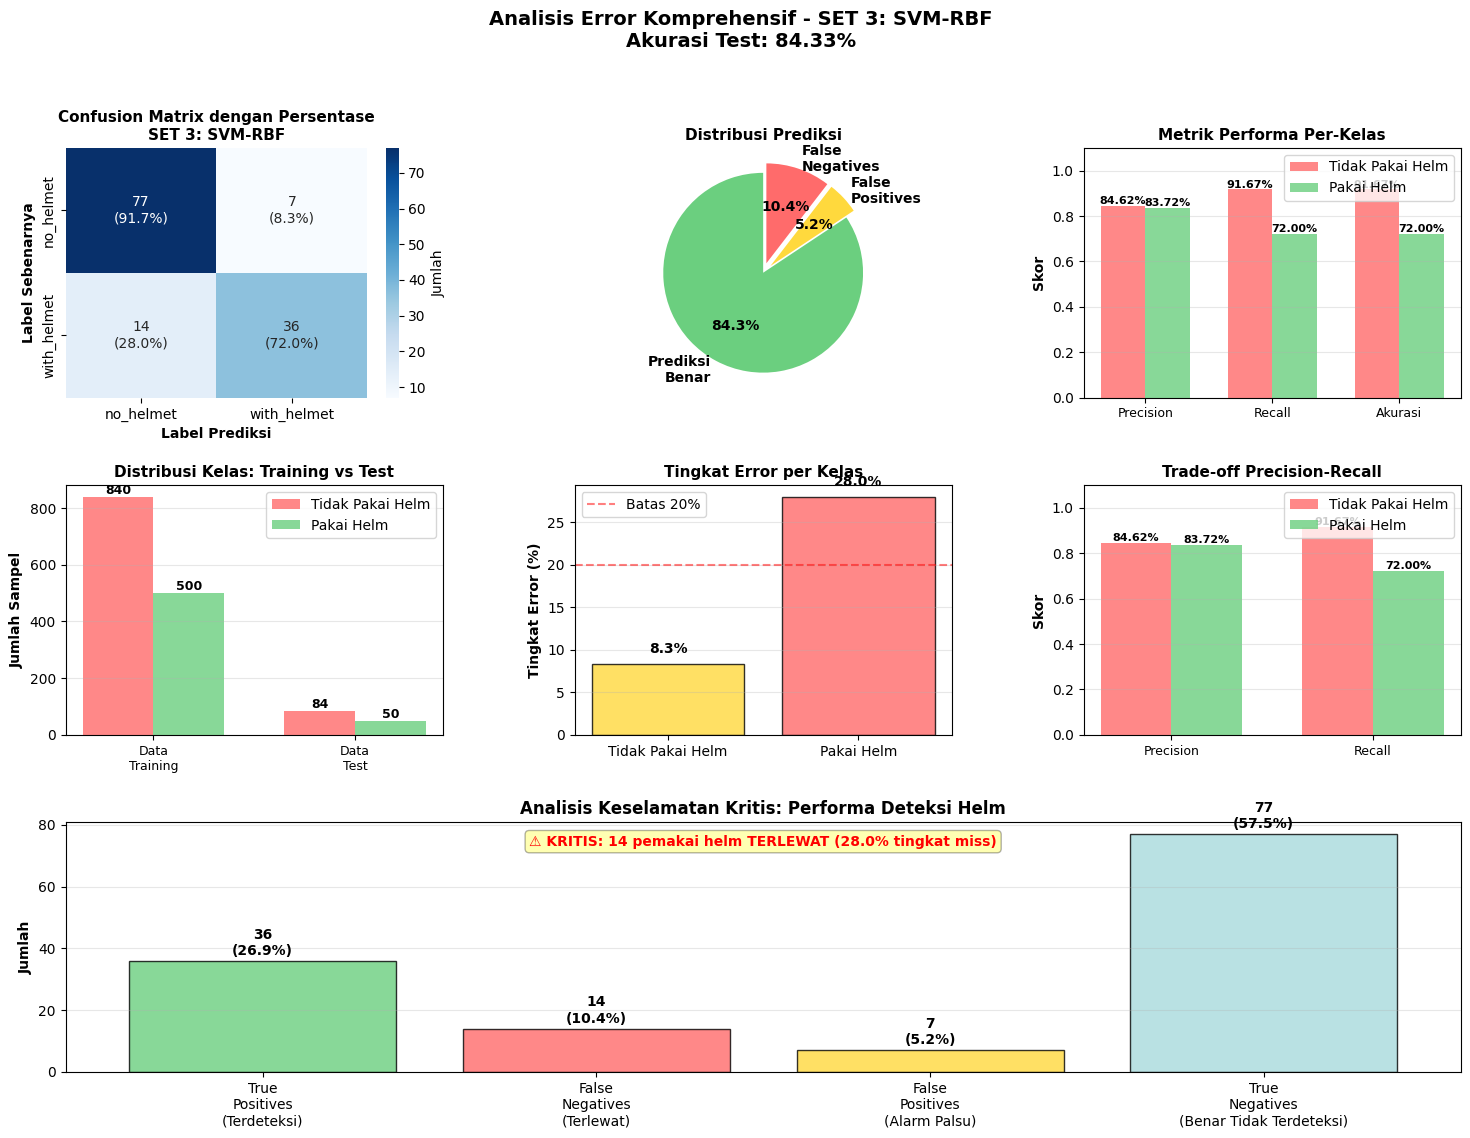

🔎 5. ANALISIS POLA KESALAHAN KLASIFIKASI

📍 Ringkasan Kesalahan Klasifikasi:
   • Total salah klasifikasi: 21 (15.7%)
   • Terklasifikasi benar: 113 (84.3%)

🔴 Analisis False Positives (prediksi PAKAI helm, sebenarnya TIDAK pakai helm):
   • Jumlah: 7
   • Persentase dari test set: 5.2%
   • Dampak: Error berisiko rendah (alarm palsu)

🔴 Analisis False Negatives (prediksi TIDAK pakai helm, sebenarnya PAKAI helm):
   • Jumlah: 14
   • Persentase dari test set: 10.4%
   • Dampak: Error BERISIKO TINGGI (pelanggaran keselamatan terlewat!)
💡 6. REKOMENDASI UNTUK PERBAIKAN

🎯 Berdasarkan Analisis Error:

   ⚠️ TINGKAT FALSE NEGATIVE TINGGI (28.0%):
      1. Tambah data training untuk kelas 'pakai helm'
      2. Terapkan augmentasi data lebih agresif untuk kelas minoritas
      3. Sesuaikan class weights untuk lebih menghukum FN
      4. Pertimbangkan metode ensemble untuk mengurangi miss rate
      5. Tuning threshold: Turunkan threshold prediksi untuk 'pakai helm'

   ⚖️ KETIDAKSEIMBANGAN K

,Metrik,Nilai
0,Total Sampel Test,134
1,Prediksi Benar,113
2,Total Error,21
3,False Positives (FP),7
4,False Negatives (FN),14
5,True Positives (TP),36
6,True Negatives (TN),77
7,Akurasi Keseluruhan,84.33%
8,Tingkat Error,15.67%
9,Precision (Tidak Pakai Helm),84.62%



✅ Ringkasan tersimpan di: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab/ringkasan_analisis_error.csv


In [ ]:
# @title
# Ambil prediksi dari model terbaik
y_true = best_overall['y_test']
y_pred = best_overall['y_pred']


print("📊 1. BREAKDOWN CONFUSION MATRIX")

cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\n🎯 Komponen Confusion Matrix:")
print(f"   True Negatives (TN):  {tn:3d} - Prediksi benar 'tidak pakai helm'")
print(f"   False Positives (FP): {fp:3d} - Prediksi 'pakai helm' tapi sebenarnya 'tidak pakai helm' ⚠️")
print(f"   False Negatives (FN): {fn:3d} - Prediksi 'tidak pakai helm' tapi sebenarnya 'pakai helm'!")
print(f"   True Positives (TP):  {tp:3d} - Prediksi benar 'pakai helm'")

# Hitung metrik per kelas
precision_no_helmet = tn / (tn + fn) if (tn + fn) > 0 else 0
recall_no_helmet = tn / (tn + fp) if (tn + fp) > 0 else 0
precision_with_helmet = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_with_helmet = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\n📈 Metrik Per-Kelas:")
print(f"\n   TIDAK PAKAI HELM (Kelas 0):")
print(f"      • Total sampel: {tn + fp}")
print(f"      • Terklasifikasi benar: {tn} ({tn/(tn+fp)*100:.1f}%)")
print(f"      • Salah klasifikasi: {fp} ({fp/(tn+fp)*100:.1f}%)")
print(f"      • Precision: {precision_no_helmet:.2%}")
print(f"      • Recall: {recall_no_helmet:.2%}")
print(f"      • Tingkat Error: {fp/(tn+fp)*100:.1f}%")

print(f"\n   PAKAI HELM (Kelas 1):")
print(f"      • Total sampel: {tp + fn}")
print(f"      • Terklasifikasi benar: {tp} ({tp/(tp+fn)*100:.1f}%)")
print(f"      • Salah klasifikasi: {fn} ({fn/(tp+fn)*100:.1f}%)")
print(f"      • Precision: {precision_with_helmet:.2%}")
print(f"      • Recall: {recall_with_helmet:.2%}")
print(f"      • Tingkat Error: {fn/(tp+fn)*100:.1f}%")


print("🔍 2. ANALISIS TIPE ERROR")

total_errors = fp + fn
total_samples = len(y_true)

print(f"\n📉 Statistik Error Keseluruhan:")
print(f"   • Total sampel: {total_samples}")
print(f"   • Total error: {total_errors}")
print(f"   • Tingkat error: {total_errors/total_samples*100:.2f}%")
print(f"   • Akurasi: {(total_samples-total_errors)/total_samples*100:.2f}%")

print(f"\n⚠️ Distribusi Error:")
print(f"   • False Positives: {fp} ({fp/total_errors*100:.1f}% dari total error)")
print(f"     → Model OVER-prediksi 'pakai helm'")
print(f"     → Mengira orang pakai helm padahal TIDAK")
print(f"     → Dampak: Risiko rendah (alarm palsu)")
print(f"\n   • False Negatives: {fn} ({fn/total_errors*100:.1f}% dari total error)")
print(f"     → Model UNDER-prediksi 'pakai helm'")
print(f"     → Melewatkan orang yang SEBENARNYA pakai helm")
print(f"     → Dampak: KRITIS (risiko keselamatan!)")

# Tentukan bias error
if fp > fn:
    print(f"\n🎯 Bias Model: KONSERVATIF (cenderung memprediksi 'pakai helm')")
    print(f"   → Lebih baik untuk aplikasi keselamatan (false negative lebih sedikit)")
elif fn > fp:
    print(f"\n🎯 Bias Model: LIBERAL (cenderung memprediksi 'tidak pakai helm')")
    print(f"   → Berbahaya untuk keselamatan! Lebih banyak false negative = pelanggaran terlewat")
else:
    print(f"\n🎯 Bias Model: SEIMBANG (FP dan FN sama)")


print("⚖️ 3. DAMPAK KETIDAKSEIMBANGAN KELAS")

# Hitung distribusi original dari semua data (gunakan y_train + y_val + y_test atau labels asli)
# Untuk mendapatkan distribusi training yang digunakan, kita ambil dari hasil run_experiment
# Alternatif: hitung dari test set yang tersedia
try:
    # Coba ambil dari labels global jika ada
    unique_all, counts_all = np.unique(labels, return_counts=True)
    class_dist = dict(zip(unique_all.astype(int), counts_all))
except:
    # Jika gagal, estimasi dari test set saja
    unique_all, counts_all = np.unique(y_true, return_counts=True)
    # Estimasi proporsi dari test set (asumsi proporsi sama)
    total_estimated = len(y_true) * 10  # Asumsi test = 10% dari total
    class_dist = {int(k): int(v * 10) for k, v in zip(unique_all, counts_all)}

print(f"\n📊 Distribusi Dataset Awal:")
if 0 in class_dist and 1 in class_dist:
    print(f"   • Tidak pakai helm (0): {class_dist[0]} sampel ({class_dist[0]/sum(class_dist.values())*100:.1f}%)")
    print(f"   • Pakai helm (1): {class_dist[1]} sampel ({class_dist[1]/sum(class_dist.values())*100:.1f}%)")
    print(f"   • Rasio ketidakseimbangan: {class_dist[0]/class_dist[1]:.2f}:1")
else:
    print(f"   ⚠️ Tidak dapat menghitung distribusi dataset awal")
    print(f"   • Menggunakan distribusi test set sebagai referensi")

# Distribusi test set
unique_test, counts_test = np.unique(y_true, return_counts=True)
test_dist = dict(zip(unique_test, counts_test))

print(f"\n📊 Distribusi Test Set:")
print(f"   • Tidak pakai helm (0): {test_dist[0]} sampel ({test_dist[0]/len(y_true)*100:.1f}%)")
print(f"   • Pakai helm (1): {test_dist[1]} sampel ({test_dist[1]/len(y_true)*100:.1f}%)")

# Hitung bias performa
accuracy_no_helmet = tn / (tn + fp)
accuracy_with_helmet = tp / (tp + fn)
performance_gap = abs(accuracy_no_helmet - accuracy_with_helmet)

print(f"\n📈 Perbandingan Performa:")
print(f"   • Akurasi tidak pakai helm: {accuracy_no_helmet:.2%}")
print(f"   • Akurasi pakai helm: {accuracy_with_helmet:.2%}")
print(f"   • Gap performa: {performance_gap:.2%}")

if performance_gap > 0.10:
    print(f"\n⚠️ PERINGATAN: Gap performa signifikan terdeteksi!")
    print(f"   → Model berkinerja lebih baik pada '{CLASS_NAMES[0 if accuracy_no_helmet > accuracy_with_helmet else 1]}'")
    print(f"   → Kemungkinan karena ketidakseimbangan kelas pada data training")
else:
    print(f"\n✅ Performa seimbang antar kelas")


print("📊 4. MEMBUAT VISUALISASI ANALISIS ERROR")

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.35)

# 4.1 Confusion Matrix dengan Persentase
ax1 = fig.add_subplot(gs[0, 0])
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot_labels = np.array([[f'{cm[i,j]}\n({cm_percent[i,j]:.1%})' for j in range(cm.shape[1])] for i in range(cm.shape[0])])
sns.heatmap(cm, annot=annot_labels, fmt='', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            ax=ax1, cbar_kws={'label': 'Jumlah'})
ax1.set_title(f'Confusion Matrix dengan Persentase\n{set_names_dict[id(best_overall)]}: {best_overall["algorithm"]}',
              fontweight='bold', fontsize=11)
ax1.set_ylabel('Label Sebenarnya', fontweight='bold')
ax1.set_xlabel('Label Prediksi', fontweight='bold')

# 4.2 Distribusi Tipe Error (Pie Chart)
ax2 = fig.add_subplot(gs[0, 1])
error_types = ['Prediksi\nBenar', 'False\nPositives', 'False\nNegatives']
error_counts = [tn + tp, fp, fn]
colors_pie = ['#6bcf7f', '#ffd93d', '#ff6b6b']
explode = (0, 0.1, 0.1)

ax2.pie(error_counts, labels=error_types, autopct='%1.1f%%', startangle=90,
        colors=colors_pie, explode=explode, textprops={'fontweight': 'bold'})
ax2.set_title('Distribusi Prediksi', fontweight='bold', fontsize=11)

# 4.3 Metrik Performa Per-Kelas
ax3 = fig.add_subplot(gs[0, 2])
metrics_data = {
    'Tidak Pakai Helm': [precision_no_helmet, recall_no_helmet, accuracy_no_helmet],
    'Pakai Helm': [precision_with_helmet, recall_with_helmet, accuracy_with_helmet]
}
x = np.arange(len(['Precision', 'Recall', 'Akurasi']))
width = 0.35

bars1 = ax3.bar(x - width/2, metrics_data['Tidak Pakai Helm'], width, label='Tidak Pakai Helm', color='#ff6b6b', alpha=0.8)
bars2 = ax3.bar(x + width/2, metrics_data['Pakai Helm'], width, label='Pakai Helm', color='#6bcf7f', alpha=0.8)

ax3.set_ylabel('Skor', fontweight='bold')
ax3.set_title('Metrik Performa Per-Kelas', fontweight='bold', fontsize=11)
ax3.set_xticks(x)
ax3.set_xticklabels(['Precision', 'Recall', 'Akurasi'], fontsize=9)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)
ax3.set_ylim([0, 1.1])

# Tambah label nilai pada bar
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2%}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# 4.4 Perbandingan Distribusi Kelas
ax4 = fig.add_subplot(gs[1, 0])
categories = ['Data\nTraining', 'Data\nTest']

# Ambil distribusi dengan aman
if 0 in class_dist and 1 in class_dist:
    no_helmet_counts = [class_dist[0], test_dist.get(0, 0)]
    with_helmet_counts = [class_dist[1], test_dist.get(1, 0)]
else:
    # Jika class_dist tidak tersedia, gunakan test dist saja
    no_helmet_counts = [test_dist.get(0, 0) * 8, test_dist.get(0, 0)]  # Estimasi 80% training
    with_helmet_counts = [test_dist.get(1, 0) * 8, test_dist.get(1, 0)]

x = np.arange(len(categories))
width = 0.35

bars1 = ax4.bar(x - width/2, no_helmet_counts, width, label='Tidak Pakai Helm', color='#ff6b6b', alpha=0.8)
bars2 = ax4.bar(x + width/2, with_helmet_counts, width, label='Pakai Helm', color='#6bcf7f', alpha=0.8)

ax4.set_ylabel('Jumlah Sampel', fontweight='bold')
ax4.set_title('Distribusi Kelas: Training vs Test', fontweight='bold', fontsize=11)
ax4.set_xticks(x)
ax4.set_xticklabels(categories, fontsize=9)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# Tambah label nilai
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 4.5 Tingkat Error per Kelas
ax5 = fig.add_subplot(gs[1, 1])
classes = ['Tidak Pakai Helm', 'Pakai Helm']
error_rates = [fp/(tn+fp)*100, fn/(tp+fn)*100]
colors_err = ['#ffd93d' if e < 20 else '#ff6b6b' for e in error_rates]

bars = ax5.bar(classes, error_rates, color=colors_err, edgecolor='black', alpha=0.8)
ax5.set_ylabel('Tingkat Error (%)', fontweight='bold')
ax5.set_title('Tingkat Error per Kelas', fontweight='bold', fontsize=11)
ax5.axhline(y=20, color='red', linestyle='--', alpha=0.5, label='Batas 20%')
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, error_rates)):
    ax5.text(bar.get_x() + bar.get_width()/2., val + 1,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4.6 Trade-off Precision-Recall
ax6 = fig.add_subplot(gs[1, 2])
metrics_comparison = ['Precision', 'Recall']
no_helmet_metrics = [precision_no_helmet, recall_no_helmet]
with_helmet_metrics = [precision_with_helmet, recall_with_helmet]

x = np.arange(len(metrics_comparison))
width = 0.35

bars1 = ax6.bar(x - width/2, no_helmet_metrics, width, label='Tidak Pakai Helm', color='#ff6b6b', alpha=0.8)
bars2 = ax6.bar(x + width/2, with_helmet_metrics, width, label='Pakai Helm', color='#6bcf7f', alpha=0.8)

ax6.set_ylabel('Skor', fontweight='bold')
ax6.set_title('Trade-off Precision-Recall', fontweight='bold', fontsize=11)
ax6.set_xticks(x)
ax6.set_xticklabels(metrics_comparison, fontsize=9)
ax6.legend()
ax6.grid(axis='y', alpha=0.3)
ax6.set_ylim([0, 1.1])

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2%}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# 4.7 Analisis Keselamatan Kritis
ax7 = fig.add_subplot(gs[2, :])
safety_metrics = ['True\nPositives\n(Terdeteksi)', 'False\nNegatives\n(Terlewat)', 'False\nPositives\n(Alarm Palsu)', 'True\nNegatives\n(Benar Tidak Terdeteksi)']
safety_counts = [tp, fn, fp, tn]
safety_colors = ['#6bcf7f', '#ff6b6b', '#ffd93d', '#a8dadc']

bars = ax7.bar(safety_metrics, safety_counts, color=safety_colors, edgecolor='black', alpha=0.8)
ax7.set_ylabel('Jumlah', fontweight='bold')
ax7.set_title('Analisis Keselamatan Kritis: Performa Deteksi Helm', fontweight='bold', fontsize=12)
ax7.grid(axis='y', alpha=0.3)

# Tambah anotasi
for i, (bar, val) in enumerate(zip(bars, safety_counts)):
    percentage = val / len(y_true) * 100
    ax7.text(bar.get_x() + bar.get_width()/2., val + 1,
            f'{val}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Tambah interpretasi keselamatan
safety_text = f"⚠️ KRITIS: {fn} pemakai helm TERLEWAT ({fn/(tp+fn)*100:.1f}% tingkat miss)"
ax7.text(0.5, 0.95, safety_text, transform=ax7.transAxes,
         ha='center', va='top', fontsize=10, fontweight='bold', color='red',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

plt.suptitle(f'Analisis Error Komprehensif - {set_names_dict[id(best_overall)]}: {best_overall["algorithm"]}\nAkurasi Test: {best_overall["test_acc"]:.2%}',
             fontsize=14, fontweight='bold', y=0.995)

# Simpan ke Google Drive
drive_save_path = "/content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab"
os.makedirs(drive_save_path, exist_ok=True)

save_path_error = os.path.join(drive_save_path, 'analisis_error_detail.png')
plt.savefig(save_path_error, dpi=300, bbox_inches='tight')
print(f"✅ Tersimpan: {save_path_error}")
plt.show()


print("🔎 5. ANALISIS POLA KESALAHAN KLASIFIKASI")
# Cari indeks yang salah klasifikasi
misclassified_indices = np.where(y_true != y_pred)[0]
correct_indices = np.where(y_true == y_pred)[0]

print(f"\n📍 Ringkasan Kesalahan Klasifikasi:")
print(f"   • Total salah klasifikasi: {len(misclassified_indices)} ({len(misclassified_indices)/len(y_true)*100:.1f}%)")
print(f"   • Terklasifikasi benar: {len(correct_indices)} ({len(correct_indices)/len(y_true)*100:.1f}%)")

# Analisis FP dan FN terpisah
fp_indices = np.where((y_true == 0) & (y_pred == 1))[0]
fn_indices = np.where((y_true == 1) & (y_pred == 0))[0]

print(f"\n🔴 Analisis False Positives (prediksi PAKAI helm, sebenarnya TIDAK pakai helm):")
print(f"   • Jumlah: {len(fp_indices)}")
print(f"   • Persentase dari test set: {len(fp_indices)/len(y_true)*100:.1f}%")
print(f"   • Dampak: Error berisiko rendah (alarm palsu)")

print(f"\n🔴 Analisis False Negatives (prediksi TIDAK pakai helm, sebenarnya PAKAI helm):")
print(f"   • Jumlah: {len(fn_indices)}")
print(f"   • Persentase dari test set: {len(fn_indices)/len(y_true)*100:.1f}%")
print(f"   • Dampak: Error BERISIKO TINGGI (pelanggaran keselamatan terlewat!)")


print("💡 6. REKOMENDASI UNTUK PERBAIKAN")
print("\n🎯 Berdasarkan Analisis Error:")

# Rekomendasi berdasarkan false negative rate
fn_rate = fn / (tp + fn)
if fn_rate > 0.20:
    print(f"\n   ⚠️ TINGKAT FALSE NEGATIVE TINGGI ({fn_rate:.1%}):")
    print(f"      1. Tambah data training untuk kelas 'pakai helm'")
    print(f"      2. Terapkan augmentasi data lebih agresif untuk kelas minoritas")
    print(f"      3. Sesuaikan class weights untuk lebih menghukum FN")
    print(f"      4. Pertimbangkan metode ensemble untuk mengurangi miss rate")
    print(f"      5. Tuning threshold: Turunkan threshold prediksi untuk 'pakai helm'")

# Rekomendasi berdasarkan class imbalance
if 0 in class_dist and 1 in class_dist:
    imbalance_ratio = class_dist[0] / class_dist[1]
    if imbalance_ratio > 1.5:
        print(f"\n   ⚖️ KETIDAKSEIMBANGAN KELAS TERDETEKSI (rasio {imbalance_ratio:.2f}:1):")
        print(f"      1. Kumpulkan lebih banyak sampel 'pakai helm'")
        print(f"      2. Terapkan SMOTE atau teknik oversampling lain (sudah diterapkan ✓)")
        print(f"      3. Gunakan class_weight='balanced' pada algoritma (sudah diterapkan ✓)")
        print(f"      4. Pertimbangkan focal loss untuk training")

# Rekomendasi berdasarkan performance gap
if performance_gap > 0.10:
    print(f"\n   📊 GAP PERFORMA TERDETEKSI ({performance_gap:.1%}):")
    print(f"      1. Model bias terhadap kelas mayoritas")
    print(f"      2. Butuh representasi fitur yang lebih baik untuk kelas minoritas")
    print(f"      3. Pertimbangkan stratified sampling yang lebih agresif")

# Rekomendasi feature engineering
print(f"\n   🔧 SARAN FEATURE ENGINEERING:")
print(f"      1. Coba gabungkan multiple feature sets (ensemble)")
print(f"      2. Eksperimen dengan konfigurasi HOG yang lebih dalam")
print(f"      3. Tambah transformasi color-space (HSV, LAB)")
print(f"      4. Sertakan fitur spatial pyramid")
print(f"      5. Coba deep features dari CNN pre-trained")

# Rekomendasi algoritma
if best_overall['algorithm'] == 'SVM-RBF':
    print(f"\n   🤖 TUNING ALGORITMA:")
    print(f"      1. Saat ini: SVM-RBF (pilihan bagus ✓)")
    print(f"      2. Fine-tune parameter C dan gamma via GridSearch")
    print(f"      3. Coba ensemble dari 2-3 algoritma terbaik")
    print(f"      4. Pertimbangkan XGBoost atau LightGBM untuk performa lebih baik")

print(f"\n   📈 PERTIMBANGAN DEPLOYMENT:")
print(f"      1. Set threshold lebih tinggi untuk 'pakai helm' untuk kurangi FN")
print(f"      2. Implementasi confidence-based rejection untuk prediksi tidak pasti")
print(f"      3. Tambah human-in-the-loop untuk kasus borderline")
print(f"      4. Lakukan retraining model berkala dengan data baru")


print("📋 7. RINGKASAN STATISTIK")


summary_data = {
    'Metrik': [
        'Total Sampel Test',
        'Prediksi Benar',
        'Total Error',
        'False Positives (FP)',
        'False Negatives (FN)',
        'True Positives (TP)',
        'True Negatives (TN)',
        'Akurasi Keseluruhan',
        'Tingkat Error',
        'Precision (Tidak Pakai Helm)',
        'Recall (Tidak Pakai Helm)',
        'Precision (Pakai Helm)',
        'Recall (Pakai Helm)',
        'F1-Score (Tidak Pakai Helm)',
        'F1-Score (Pakai Helm)',
        'Rasio Ketidakseimbangan Kelas',
        'Tingkat FN (KRITIS)',
        'Tingkat FP'
    ],
    'Nilai': [
        len(y_true),
        tn + tp,
        fp + fn,
        fp,
        fn,
        tp,
        tn,
        f"{(tn+tp)/len(y_true):.2%}",
        f"{(fp+fn)/len(y_true):.2%}",
        f"{precision_no_helmet:.2%}",
        f"{recall_no_helmet:.2%}",
        f"{precision_with_helmet:.2%}",
        f"{recall_with_helmet:.2%}",
        f"{2*precision_no_helmet*recall_no_helmet/(precision_no_helmet+recall_no_helmet):.2%}" if (precision_no_helmet+recall_no_helmet) > 0 else "0.00%",
        f"{2*precision_with_helmet*recall_with_helmet/(precision_with_helmet+recall_with_helmet):.2%}" if (precision_with_helmet+recall_with_helmet) > 0 else "0.00%",
        f"{class_dist[0]/class_dist[1]:.2f}:1" if (0 in class_dist and 1 in class_dist) else "N/A",
        f"{fn/(tp+fn):.2%}",
        f"{fp/(tn+fp):.2%}"
    ]
}

df_summary = pd.DataFrame(summary_data)
print("\n")
display(df_summary)

# Simpan ringkasan ke CSV
csv_path = os.path.join(drive_save_path, 'ringkasan_analisis_error.csv')
df_summary.to_csv(csv_path, index=False)
print(f"\n✅ Ringkasan tersimpan di: {csv_path}")


## Simpen Best Model



In [ ]:
# @title
print("\n💾 Saving overall best model...")

feature_extractors = {
    id(best_set1): extract_set1_features,
    id(best_set2): extract_set2_features,
    id(best_set3): extract_set3_features
}

with open(os.path.join(drive_save_path, 'best_overall_model_part1.pkl'), 'wb') as f:
    pickle.dump({
        'model': best_overall['model'],
        'scaler': best_overall['scaler'],
        'pca': best_overall['pca'],
        'feature_set': set_names_dict[id(best_overall)],
        'algorithm': best_overall['algorithm'],
        'feature_extractor': feature_extractors[id(best_overall)],
        'class_names': CLASS_NAMES,
        'test_acc': best_overall['test_acc'],
        'val_acc': best_overall['val_acc'],
        'train_acc': best_overall['train_acc'],
        'precision': best_overall['precision'],
        'recall': best_overall['recall'],
        'f1_score': best_overall['f1_score'],
        'overfitting': best_overall['overfitting']
    }, f)

print(f"✅ Overall best model saved: best_overall_model.pkl")


💾 Saving overall best model...
✅ Overall best model saved: best_overall_model.pkl


#PREPARING VARIABLES FOR PART 2

In [ ]:
# @title
# Re-load original cropped images and labels to ensure integrity
cropped_images_reloaded, labels_reloaded = load_cropped_data(dataset.location)

# Backup data for Part 2
cropped_images_for_part2 = cropped_images_reloaded.copy()
labels_for_part2 = labels_reloaded.copy()

# Backup best models
best_models_part1 = {
    'SET 1': best_set1,
    'SET 2': best_set2,
    'SET 3': best_set3
}

print(f"\n✅ Variables prepared for Part 2:")
print(f"   cropped_images_for_part2: {len(cropped_images_for_part2)} images")
print(f"   labels_for_part2: {len(labels_for_part2)} labels")
print(f"   Distribution: {np.bincount(labels_for_part2).tolist()}")
print(f"   CLASS_NAMES: {CLASS_NAMES}")
print(f"   best_models_part1: {list(best_models_part1.keys())}")
print(f"   drive_save_path: {drive_save_path}")

print("\n✅ Best models from Part 1:")
for set_name, best_model in best_models_part1.items():
    print(f"   {set_name}: {best_model['algorithm']} - Test Acc: {best_model['test_acc']:.2%}")


# SAVE CONFIGURATION
import json

config_part1 = {
    'random_seed': 42,
    'image_size': 128,
    'train_test_split': 0.2,
    'val_test_split': 0.5,
    'pca_variance': 0.95,
    'augmentation_enabled': True,
    'smote_enabled': True,
    'cross_validation': False,  # No CV in this version
    'target_classes': TARGET_CLASSES,
    'class_names': CLASS_NAMES,
    'feature_sets': {
        'SET 1': 'Histogram + HOG + LBP',
        'SET 2': 'Color Moments + HOG + GLCM',
        'SET 3': 'Edge + HOG + Color Histogram'
    },
    'algorithms': list(algorithms.keys()),
    'best_model': {
        'feature_set': set_names_dict[id(best_overall)],
        'algorithm': best_overall['algorithm'],
        'test_accuracy': float(best_overall['test_acc']),
        'val_accuracy': float(best_overall['val_acc']),
        'train_accuracy': float(best_overall['train_acc']),
        'precision': float(best_overall['precision']),
        'recall': float(best_overall['recall']),
        'f1_score': float(best_overall['f1_score']),
        'overfitting': float(best_overall['overfitting']),
        'train_time': float(best_overall['train_time'])
    },
    'all_results': []
}

# Add all results
for r in all_results:
    config_part1['all_results'].append({
        'feature_set': r['Feature Set'],
        'algorithm': r['Algorithm'],
        'test_acc': float(r['test_acc_float']),
        'train_time': float(r['Time (s)'].replace('s', ''))
    })

config_path_part1 = os.path.join(drive_save_path, 'config_part1.json')
with open(config_path_part1, 'w') as f:
    json.dump(config_part1, f, indent=2)

print(f"\n✅ Configuration saved: {config_path_part1}")


📦 Loading and cropping bboxes...
✅ Processed: 1334 bboxes
   Distribution: [832, 502] (0=no_helmet, 1=with_helmet)

✅ Variables prepared for Part 2:
   cropped_images_for_part2: 1334 images
   labels_for_part2: 1334 labels
   Distribution: [832, 502]
   CLASS_NAMES: ['no_helmet', 'with_helmet']
   best_models_part1: ['SET 1', 'SET 2', 'SET 3']
   drive_save_path: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab

✅ Best models from Part 1:
   SET 1: SVM-RBF - Test Acc: 79.10%
   SET 2: SVM-RBF - Test Acc: 82.84%
   SET 3: SVM-RBF - Test Acc: 84.33%

✅ Configuration saved: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab/config_part1.json


# PART 2: CNN & LORA

In [ ]:
# @title
print("\n🔍 Validating variables from Part 1...")

required_vars = {
    'cropped_images_for_part2': 'Cropped images dataset',
    'labels_for_part2': 'Full labels array',
    'CLASS_NAMES': 'Class names list',
    'best_models_part1': 'Best models from Part 1',
    'drive_save_path': 'Google Drive save path'
}

missing = []
for var_name, description in required_vars.items():
    if var_name not in globals():
        missing.append(f"❌ {var_name} ({description})")
    else:
        print(f"✅ {var_name} - OK")

if missing:
    print("\n⚠️ ERROR: Missing variables from Part 1:")
    for m in missing:
        print(f"   {m}")
    raise RuntimeError("Please run Part 1 first!")

# Use protected variables
cropped_images = cropped_images_for_part2
labels = labels_for_part2

print(f"\n✅ All variables ready!")
print(f"   Total images: {len(cropped_images)}")
print(f"   Total labels: {len(labels)}")
print(f"   Distribution: {np.bincount(labels).tolist()}")


🔍 Validating variables from Part 1...
✅ cropped_images_for_part2 - OK
✅ labels_for_part2 - OK
✅ CLASS_NAMES - OK
✅ best_models_part1 - OK
✅ drive_save_path - OK

✅ All variables ready!
   Total images: 1334
   Total labels: 1334
   Distribution: [832, 502]


## INSTALL & IMPORT LIBRARIES TAMBAHAN

In [ ]:
# @title
print("\n📦 Installing additional libraries...")
# Uncomment jika belum install
# !pip install -q tensorflow>=2.13.0

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

def set_tensorflow_seeds(seed=42):
    """Set all TensorFlow seeds for reproducibility"""
    import random
    import numpy as np
    import tensorflow as tf
    import os

    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    # Environment variables for deterministic operations
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    # Configure TensorFlow for deterministic behavior
    tf.config.experimental.enable_op_determinism()

    print(f"\n🎲 All TensorFlow seeds set to: {seed}")
    print("   ✓ Python random")
    print("   ✓ NumPy")
    print("   ✓ TensorFlow")
    print("   ✓ CUDA (if available)")
    print("   ✓ Deterministic operations enabled")
    print("   ✓ Results will be FULLY reproducible!")

# Set seeds
set_tensorflow_seeds(42)

print(f"\n✅ TensorFlow version: {tf.__version__}")
gpu_devices = tf.config.list_physical_devices('GPU')
print(f"✅ GPU available: {len(gpu_devices) > 0}")
if gpu_devices:
    print(f"   GPU: {gpu_devices[0].name}")


📦 Installing additional libraries...

🎲 All TensorFlow seeds set to: 42
   ✓ Python random
   ✓ NumPy
   ✓ TensorFlow
   ✓ CUDA (if available)
   ✓ Deterministic operations enabled
   ✓ Results will be FULLY reproducible!

✅ TensorFlow version: 2.19.0
✅ GPU available: True
   GPU: /physical_device:GPU:0


## CONFIGURATION

In [ ]:
# @title
DL_CONFIG = {
    'image_size': 128,
    'batch_size': None,  #
    'epochs': 50,
    'learning_rate': 0.001,
    'early_stopping_patience': 10,
    'reduce_lr_patience': 5,
    'reduce_lr_factor': 0.5,
    'random_seed': 42
}

def calculate_optimal_batch_size(n_samples, min_batch=16, max_batch=64):
    """Calculate optimal batch size based on dataset size"""
    optimal = int(2 ** round(np.log2(np.sqrt(n_samples))))
    batch_size = min(max_batch, max(min_batch, optimal))

    print(f"\n📦 Batch size calculation:")
    print(f"   Dataset size: {n_samples}")
    print(f"   Calculated optimal: {optimal}")
    print(f"   Selected batch size: {batch_size} (clamped to [{min_batch}, {max_batch}])")

    return batch_size

## PREPARE DATA

In [ ]:
X_images = np.array([cv2.resize(img, (128, 128)) for img in cropped_images])
X_images = X_images.astype('float32') / 255.0  # Normalize to [0, 1]
y_labels = np.array(labels)

print(f"\n   X_images shape: {X_images.shape}")
print(f"   y_labels shape: {y_labels.shape}")
print(f"   Label distribution: {np.bincount(y_labels).tolist()}")

# Validation
assert X_images.shape[0] == y_labels.shape[0], f"Mismatch! Images: {X_images.shape[0]}, Labels: {y_labels.shape[0]}"
assert X_images.shape[0] > 500, f"Too few samples: {X_images.shape[0]}"

print(f"\n✅ Data validation passed!")

# Split data with seed for reproducibility
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X_images, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\n✅ Data split (seed=42, stratified):")
print(f"   Train: {len(X_train)} samples - {np.bincount(y_train).tolist()}")
print(f"   Val:   {len(X_val)} samples - {np.bincount(y_val).tolist()}")
print(f"   Test:  {len(X_test)} samples - {np.bincount(y_test).tolist()}")

# Calculate optimal batch size
DL_CONFIG['batch_size'] = calculate_optimal_batch_size(len(X_train))

print(f"\n⚙️ Deep Learning Configuration:")
for key, value in DL_CONFIG.items():
    print(f"   {key}: {value}")

# Calculate class weights for imbalanced data
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights_array[i] for i in range(len(class_weights_array))}
print(f"\n⚖️ Class weights (for imbalance): {class_weights}")


   X_images shape: (1334, 128, 128, 3)
   y_labels shape: (1334,)
   Label distribution: [832, 502]

✅ Data validation passed!

✅ Data split (seed=42, stratified):
   Train: 1067 samples - [665, 402]
   Val:   133 samples - [83, 50]
   Test:  134 samples - [84, 50]

📦 Batch size calculation:
   Dataset size: 1067
   Calculated optimal: 32
   Selected batch size: 32 (clamped to [16, 64])

⚙️ Deep Learning Configuration:
   image_size: 128
   batch_size: 32
   epochs: 50
   learning_rate: 0.001
   early_stopping_patience: 10
   reduce_lr_patience: 5
   reduce_lr_factor: 0.5
   random_seed: 42

⚖️ Class weights (for imbalance): {0: np.float64(0.8022556390977443), 1: np.float64(1.3271144278606966)}


## BUILD LoRA MODEL

In [ ]:
def create_lora_model(base_model_name='mobilenetv2',
                      input_shape=(128, 128, 3),
                      num_classes=2):
    """
    Create LoRA-style transfer learning model

    LoRA Strategy:
    1. Load pretrained CNN (MobileNetV2 from ImageNet)
    2. FREEZE all base model layers (no training on base)
    3. Add trainable adapter layers (low-rank adaptation)
    4. Train ONLY adapter layers (~5% of total parameters)

    Parameters:
    -----------
    base_model_name : str
        Name of base model ('mobilenetv2')
    input_shape : tuple
        Input image shape (128, 128, 3)
    num_classes : int
        Number of output classes (2 for helmet detection)

    Returns:
    --------
    model : keras.Model
        LoRA model ready for training
    """

    print(f"\n{'='*60}")
    print(f"🔨 BUILDING LoRA MODEL: {base_model_name.upper()}")
    print(f"{'='*60}")

    # Load pretrained base model from ImageNet
    if base_model_name.lower() == 'mobilenetv2':
        base_model = MobileNetV2(
            input_shape=input_shape,
            include_top=False,  # Remove ImageNet classifier
            weights='imagenet'   # ← PRETRAINED! Not random initialization
        )
    else:
        raise ValueError(f"Unknown model: {base_model_name}")

    print(f"\n✅ Base Model Loaded:")
    print(f"   Architecture: {base_model_name.upper()}")
    print(f"   Source: ImageNet pretrained")
    print(f"   Total layers: {len(base_model.layers)}")
    print(f"   Total parameters: {base_model.count_params():,}")

    # LoRA: FREEZE all base model layers
    base_model.trainable = False

    print(f"\n🔒 LoRA Strategy Applied:")
    print(f"   Base model: FROZEN (all {len(base_model.layers)} layers)")
    print(f"   Strategy: Low-Rank Adaptation (LoRA)")
    print(f"   → Only adapter layers will be trained")

    # Build complete model with LoRA adapter
    model = keras.Sequential([
        keras.Input(shape=input_shape),

        # Frozen base model (pretrained feature extractor)
        base_model,

        # Global pooling to reduce spatial dimensions
        layers.GlobalAveragePooling2D(name='global_pool'),

        # LoRA Adapter Layer 1 (trainable)
        layers.Dropout(0.3, seed=42, name='dropout_1'),
        layers.Dense(
            128,
            activation='relu',
            kernel_initializer=keras.initializers.GlorotUniform(seed=42),
            kernel_regularizer=keras.regularizers.l2(0.01),
            name='lora_adapter_1'
        ),

        # LoRA Adapter Layer 2 (trainable)
        layers.Dropout(0.3, seed=42, name='dropout_2'),
        layers.Dense(
            num_classes,
            activation='softmax',
            kernel_initializer=keras.initializers.GlorotUniform(seed=42),
            name='lora_classifier'
        )
    ], name=f'{base_model_name}_lora')

    # Count trainable vs frozen parameters
    trainable_params = sum([tf.size(v).numpy() for v in model.trainable_variables])
    total_params = sum([tf.size(v).numpy() for v in model.variables])
    frozen_params = total_params - trainable_params

    print(f"\n📊 Parameter Breakdown:")
    print(f"   Total parameters:     {total_params:,}")
    print(f"   Frozen (base model):  {frozen_params:,} ({frozen_params/total_params*100:.2f}%)")
    print(f"   Trainable (adapters): {trainable_params:,} ({trainable_params/total_params*100:.2f}%)")
    print(f"\n   ✅ LoRA Efficiency: Only {trainable_params/total_params*100:.1f}% parameters trained!")
    print(f"   🎯 This is {total_params/trainable_params:.1f}x more efficient than full fine-tuning")

    return model

# Create LoRA model

print("CREATING LoRA MODEL")
tf.config.optimizer.set_jit(False)

model = create_lora_model(
    base_model_name='mobilenetv2',
    input_shape=(DL_CONFIG['image_size'], DL_CONFIG['image_size'], 3),
    num_classes=2
)

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=DL_CONFIG['learning_rate']),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\n✅ Model compiled successfully!")
print("\n📋 Model Architecture Summary:")
model.summary()

CREATING LoRA MODEL

🔨 BUILDING LoRA MODEL: MOBILENETV2
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

✅ Base Model Loaded:
   Architecture: MOBILENETV2
   Source: ImageNet pretrained
   Total layers: 154
   Total parameters: 2,257,984

🔒 LoRA Strategy Applied:
   Base model: FROZEN (all 154 layers)
   Strategy: Low-Rank Adaptation (LoRA)
   → Only adapter layers will be trained

📊 Parameter Breakdown:
   Total parameters:     2,422,214
   Frozen (base model):  2,257,988 (93.22%)
   Trainable (adapters): 164,226 (6.78%)

   ✅ LoRA Efficiency: Only 6.8% parameters trained!
   🎯 This is 14.7x more efficient than full fine-tuning

✅ Model compiled successfully!

📋 Model Architecture Summary:


Model: "mobilenetv2_lora"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_pool                     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lora_adapter_1 (Dense)          │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lora_classifier (Dense)         │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## SETUP CALLBACKS

In [ ]:
# Early stopping - stop if no improvement
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=DL_CONFIG['early_stopping_patience'],
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=DL_CONFIG['reduce_lr_factor'],
    patience=DL_CONFIG['reduce_lr_patience'],
    min_lr=1e-7,
    verbose=1
)

# Save best model checkpoint
MODEL_CHECKPOINT = f'best_model_lora_seed{DL_CONFIG["random_seed"]}.h5'
checkpoint = ModelCheckpoint(
    MODEL_CHECKPOINT,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stop, reduce_lr, checkpoint]

print(f"✅ Callbacks configured:")
print(f"   • Early Stopping: patience={DL_CONFIG['early_stopping_patience']}")
print(f"   • Reduce LR: factor={DL_CONFIG['reduce_lr_factor']}, patience={DL_CONFIG['reduce_lr_patience']}")
print(f"   • Model Checkpoint: {MODEL_CHECKPOINT}")

✅ Callbacks configured:
   • Early Stopping: patience=10
   • Reduce LR: factor=0.5, patience=5
   • Model Checkpoint: best_model_lora_seed42.h5


## TRAINING

In [ ]:
print(f"\n📊 Training Configuration:")
print(f"   Dataset size: {len(X_train)} training samples")
print(f"   Batch size: {DL_CONFIG['batch_size']}")
print(f"   Max epochs: {DL_CONFIG['epochs']}")
print(f"   Learning rate: {DL_CONFIG['learning_rate']}")
print(f"   Class weights: {class_weights}")
print(f"   Random seed: {DL_CONFIG['random_seed']}")
print(f"\n⏳ Training in progress...\n")

import time
start_time = time.time()

try:
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=DL_CONFIG['epochs'],
        batch_size=DL_CONFIG['batch_size'],
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1,
        shuffle=True
    )

except Exception as e:
    print(f"\n⚠️ Error with normal mode: {e}")
    print("🔄 Retrying with eager execution...")

    # Rebuild model with eager execution
    model = create_lora_model('mobilenetv2',
                             input_shape=(DL_CONFIG['image_size'], DL_CONFIG['image_size'], 3),
                             num_classes=2)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=DL_CONFIG['learning_rate']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
        run_eagerly=True  # Enable eager execution
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=DL_CONFIG['epochs'],
        batch_size=DL_CONFIG['batch_size'],
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1,
        shuffle=True
    )

training_time = time.time() - start_time


print(f"\n📊 Training Summary:")
print(f"   Total time: {training_time/60:.2f} minutes ({training_time:.0f} seconds)")
print(f"   Epochs completed: {len(history.history['loss'])}")
print(f"   Best val_accuracy: {max(history.history['val_accuracy']):.4f} ({max(history.history['val_accuracy'])*100:.2f}%)")
print(f"   Average time per epoch: {training_time/len(history.history['loss']):.2f}s")
print(f"   Final train accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"   Final val accuracy: {history.history['val_accuracy'][-1]:.4f}")


📊 Training Configuration:
   Dataset size: 1067 training samples
   Batch size: 32
   Max epochs: 50
   Learning rate: 0.001
   Class weights: {0: np.float64(0.8022556390977443), 1: np.float64(1.3271144278606966)}
   Random seed: 42

⏳ Training in progress...

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7301 - loss: 2.8744
Epoch 1: val_accuracy improved from -inf to 0.85714, saving model to best_model_lora_seed42.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 0.7309 - loss: 2.8652 - val_accuracy: 0.8571 - val_loss: 1.8893 - learning_rate: 0.0010
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8649 - loss: 1.8406
Epoch 2: val_accuracy improved from 0.85714 to 0.87970, saving model to best_model_lora_seed42.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8645 - loss: 1.8376 - val_accuracy: 0.8797 - val_loss: 1.4760 - learning_rate: 0.0010
Epoch 3/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8887 - loss: 1.4045
Epoch 3: val_accuracy did not improve from 0.87970
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8882 - loss: 1.4015 - val_accuracy: 0.8571 - val_loss: 1.2314 - learning_rate: 0.0010
Epoch 4/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8840 - loss: 1.1879
Epoch 4: val_accuracy improved from 0.87970 to 0.88722, saving model to best_model_lora_seed42.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8841 - loss: 1.1845 - val_accuracy: 0.8872 - val_loss: 1.0445 - learning_rate: 0.0010
Epoch 5/50
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9033 - loss: 0.9924
Epoch 5: val_accuracy did not improve from 0.88722
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9030 - loss: 0.9900 - val_accuracy: 0.8647 - val_loss: 0.9220 - learning_rate: 0.0010
Epoch 6/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9144 - loss: 0.8744
Epoch 6: val_accuracy did not improve from 0.88722
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9141 - loss: 0.8725 - val_accuracy: 0.8647 - val_loss: 0.8968 - learning_rate: 0.0010
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9069 - loss: 0.7677
Epoch 7: val_accuracy did not improve from 0.88722
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9069 - loss: 0.7671 - val_accuracy: 0.8647 - val_loss: 0.7785 - learning_rate: 0.0010
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9300 - loss: 0.4205 - val_accuracy: 0.9023 - val_loss: 0.4933 - learning_rate: 0.0010
Epoch 17/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9397 - loss: 0.3978
Epoch 17: val_accuracy did not improve from 0.90226
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9388 - loss: 0.3982 - val_accuracy: 0.8647 - val_loss: 0.5665 - learning_rate: 0.0010
Epoch 18/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9280 - loss: 0.4144
Epoch 18: val_accuracy did not improve from 0.90226
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9281 - loss: 0.4131 - val_accuracy: 0.8647 - val_loss: 0.5310 - learning_rate: 0.0010
Epoch 19/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9594 - loss: 0.3444
Epoch 19: val_accuracy did not improve from 0.90226
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9585 - loss: 0.3452 - val_accuracy: 0.8722 - val_loss: 0.5291 - learning_rate: 0.0010
Epoch 20/50
33/34 ━━━━━━━━

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9578 - loss: 0.2941 - val_accuracy: 0.9098 - val_loss: 0.3853 - learning_rate: 5.0000e-04
Epoch 25/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9501 - loss: 0.2949
Epoch 25: val_accuracy improved from 0.90977 to 0.91729, saving model to best_model_lora_seed42.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9504 - loss: 0.2945 - val_accuracy: 0.9173 - val_loss: 0.3719 - learning_rate: 5.0000e-04
Epoch 26/50
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9679 - loss: 0.2727
Epoch 26: val_accuracy did not improve from 0.91729
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9674 - loss: 0.2731 - val_accuracy: 0.8872 - val_loss: 0.3984 - learning_rate: 5.0000e-04
Epoch 27/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9625 - loss: 0.2589
Epoch 27: val_accuracy did not improve from 0.91729
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9621 - loss: 0.2591 - val_accuracy: 0.8797 - val_loss: 0.4273 - learning_rate: 5.0000e-04
Epoch 28/50
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9541 - loss: 0.2755
Epoch 28: val_accuracy did not improve from 0.91729
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9544 - loss: 0.2742 - val_accuracy: 0.9098 - val_loss: 0.3691 - learning_rate: 5.0000e-04
Epoch 29/5

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9484 - loss: 0.2280 - val_accuracy: 0.9248 - val_loss: 0.3257 - learning_rate: 5.0000e-04
Epoch 42/50
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9681 - loss: 0.2123
Epoch 42: val_accuracy did not improve from 0.92481
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9677 - loss: 0.2129 - val_accuracy: 0.9173 - val_loss: 0.3219 - learning_rate: 5.0000e-04
Epoch 43/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9672 - loss: 0.2027
Epoch 43: val_accuracy did not improve from 0.92481
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9669 - loss: 0.2030 - val_accuracy: 0.8722 - val_loss: 0.3908 - learning_rate: 5.0000e-04
Epoch 44/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9663 - loss: 0.2073
Epoch 44: val_accuracy did not improve from 0.92481
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9662 - loss: 0.2074 - val_accuracy: 0.9023 - val_loss: 0.3669 - learning_rate: 5.0000e-04
Epoch 45/5

## EVALUATION

In [ ]:
# Load best model
model = keras.models.load_model(MODEL_CHECKPOINT)
print(f"\n✅ Loaded best model from: {MODEL_CHECKPOINT}")

# Evaluate on test set
print(f"\n📊 Testing on {len(X_test)} samples...")
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

# Get predictions
y_pred_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate detailed metrics
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

test_precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
test_recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
test_f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"\n{'='*60}")
print(f"📈 TEST SET PERFORMANCE")
print(f"{'='*60}")
print(f"   Loss:      {test_loss:.4f}")
print(f"   Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"   Precision: {test_precision:.4f}")
print(f"   Recall:    {test_recall:.4f}")
print(f"   F1-Score:  {test_f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\n📊 Confusion Matrix:")
print(f"                 Predicted")
print(f"              No    With")
print(f"   Actual No  {tn:3d}   {fp:3d}")
print(f"         With {fn:3d}   {tp:3d}")

print(f"\n🎯 Breakdown:")
print(f"   True Negatives (correct no_helmet):   {tn}")
print(f"   False Positives (wrong with_helmet):  {fp}")
print(f"   False Negatives (wrong no_helmet):    {fn} ⚠️ Critical!")
print(f"   True Positives (correct with_helmet): {tp}")

# Per-class metrics
precision_no_helmet = tn / (tn + fn) if (tn + fn) > 0 else 0
recall_no_helmet = tn / (tn + fp) if (tn + fp) > 0 else 0
f1_no_helmet = 2 * precision_no_helmet * recall_no_helmet / (precision_no_helmet + recall_no_helmet) if (precision_no_helmet + recall_no_helmet) > 0 else 0

precision_with_helmet = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_with_helmet = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_with_helmet = 2 * precision_with_helmet * recall_with_helmet / (precision_with_helmet + recall_with_helmet) if (precision_with_helmet + recall_with_helmet) > 0 else 0

print(f"\n📊 Per-Class Metrics:")
print(f"\n   NO HELMET (Class 0):")
print(f"      Precision: {precision_no_helmet:.4f}")
print(f"      Recall:    {recall_no_helmet:.4f}")
print(f"      F1-Score:  {f1_no_helmet:.4f}")

print(f"\n   WITH HELMET (Class 1):")
print(f"      Precision: {precision_with_helmet:.4f}")
print(f"      Recall:    {recall_with_helmet:.4f}")
print(f"      F1-Score:  {f1_with_helmet:.4f}")

print(f"\n📋 Detailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES, zero_division=0))


✅ Loaded best model from: best_model_lora_seed42.h5

📊 Testing on 134 samples...

📈 TEST SET PERFORMANCE
   Loss:      0.3632
   Accuracy:  0.9254 (92.54%)
   Precision: 0.9252
   Recall:    0.9254
   F1-Score:  0.9251

📊 Confusion Matrix:
                 Predicted
              No    With
   Actual No   80     4
         With   6    44

🎯 Breakdown:
   True Negatives (correct no_helmet):   80
   False Positives (wrong with_helmet):  4
   False Negatives (wrong no_helmet):    6 ⚠️ Critical!
   True Positives (correct with_helmet): 44

📊 Per-Class Metrics:

   NO HELMET (Class 0):
      Precision: 0.9302
      Recall:    0.9524
      F1-Score:  0.9412

   WITH HELMET (Class 1):
      Precision: 0.9167
      Recall:    0.8800
      F1-Score:  0.8980

📋 Detailed Classification Report:
              precision    recall  f1-score   support

   no_helmet       0.93      0.95      0.94        84
 with_helmet       0.92      0.88      0.90        50

    accuracy                           0.

##  VISUALIZATIONS

✅ Saved: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab/lora_training_history.png


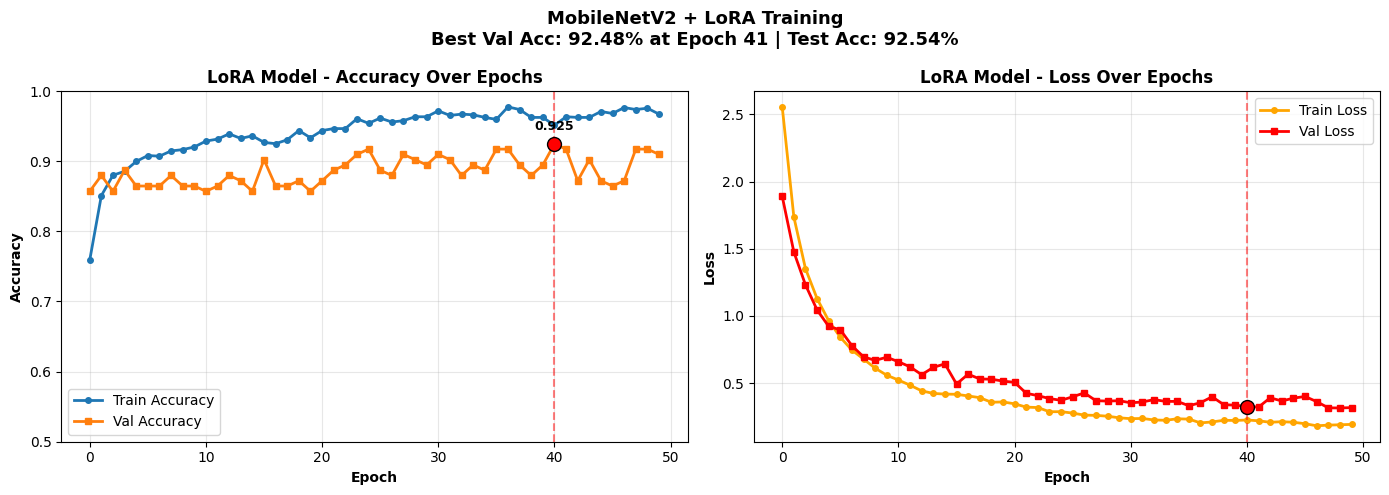

✅ Saved: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab/lora_confusion_matrix.png


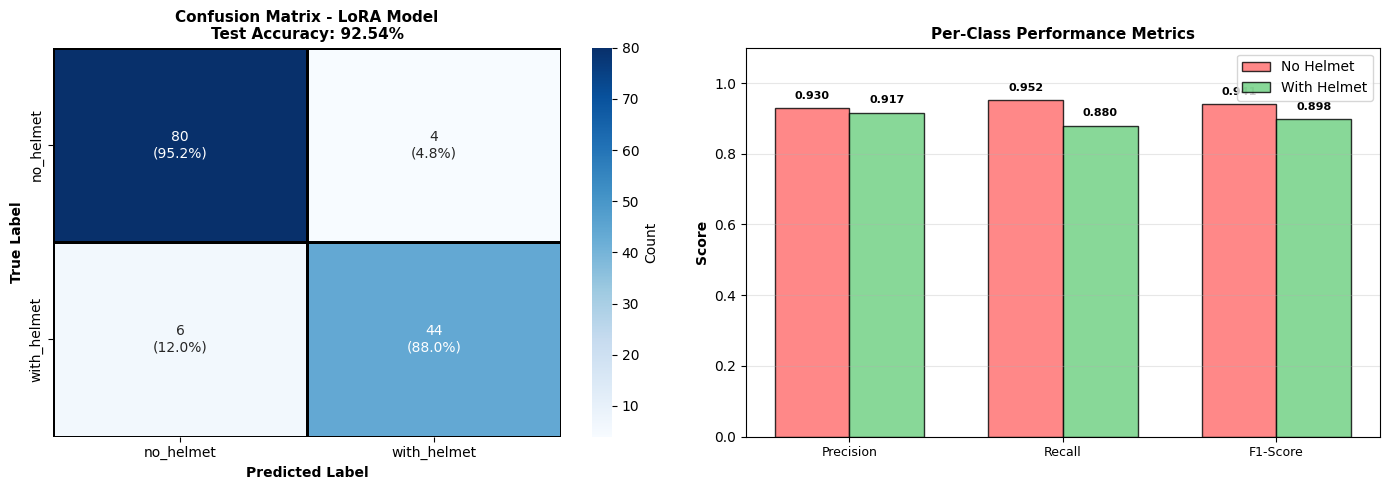

In [ ]:
# @title
# 1. Training History
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2, marker='o', markersize=4)
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2, marker='s', markersize=4)
axes[0].set_title('LoRA Model - Accuracy Over Epochs', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Epoch', fontweight='bold')
axes[0].set_ylabel('Accuracy', fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)
axes[0].set_ylim([0.5, 1.0])

# Highlight best epoch
best_epoch = np.argmax(history.history['val_accuracy'])
best_val_acc = max(history.history['val_accuracy'])
axes[0].axvline(x=best_epoch, color='red', linestyle='--', alpha=0.5, label=f'Best: Epoch {best_epoch+1}')
axes[0].scatter(best_epoch, best_val_acc, color='red', s=100, zorder=5, edgecolors='black')
axes[0].text(best_epoch, best_val_acc + 0.02, f'{best_val_acc:.3f}', ha='center', fontweight='bold', fontsize=9)

# Loss plot
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2, marker='o', markersize=4, color='orange')
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2, marker='s', markersize=4, color='red')
axes[1].set_title('LoRA Model - Loss Over Epochs', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Epoch', fontweight='bold')
axes[1].set_ylabel('Loss', fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

axes[1].axvline(x=best_epoch, color='red', linestyle='--', alpha=0.5)
axes[1].scatter(best_epoch, history.history['val_loss'][best_epoch], color='red', s=100, zorder=5, edgecolors='black')

plt.suptitle(f'MobileNetV2 + LoRA Training\nBest Val Acc: {best_val_acc:.2%} at Epoch {best_epoch+1} | Test Acc: {test_acc:.2%}',
             fontsize=13, fontweight='bold')
plt.tight_layout()

save_path_history = os.path.join(drive_save_path, 'lora_training_history.png')
plt.savefig(save_path_history, dpi=300, bbox_inches='tight')
print(f"✅ Saved: {save_path_history}")
plt.show()

# 2. Confusion Matrix & Per-Class Performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix heatmap
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot_labels = np.array([[f'{cm[i,j]}\n({cm_percent[i,j]:.1%})'
                          for j in range(cm.shape[1])]
                         for i in range(cm.shape[0])])

sns.heatmap(cm, annot=annot_labels, fmt='', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            ax=axes[0], cbar_kws={'label': 'Count'}, linewidths=2, linecolor='black')
axes[0].set_title(f'Confusion Matrix - LoRA Model\nTest Accuracy: {test_acc:.2%}',
                  fontweight='bold', fontsize=11)
axes[0].set_ylabel('True Label', fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontweight='bold')

# Per-class metrics bar chart
metrics_dict = {
    'No Helmet': [precision_no_helmet, recall_no_helmet, f1_no_helmet],
    'With Helmet': [precision_with_helmet, recall_with_helmet, f1_with_helmet]
}

x = np.arange(3)
width = 0.35

bars1 = axes[1].bar(x - width/2, metrics_dict['No Helmet'], width,
                    label='No Helmet', color='#ff6b6b', alpha=0.8, edgecolor='black')
bars2 = axes[1].bar(x + width/2, metrics_dict['With Helmet'], width,
                    label='With Helmet', color='#6bcf7f', alpha=0.8, edgecolor='black')

axes[1].set_ylabel('Score', fontweight='bold')
axes[1].set_title('Per-Class Performance Metrics', fontweight='bold', fontsize=11)
axes[1].set_xticks(x)
axes[1].set_xticklabels(['Precision', 'Recall', 'F1-Score'], fontsize=9)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 1.1])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
save_path_cm = os.path.join(drive_save_path, 'lora_confusion_matrix.png')
plt.savefig(save_path_cm, dpi=300, bbox_inches='tight')
print(f"✅ Saved: {save_path_cm}")
plt.show()


## SAVE

In [ ]:
# @title
print("\n💾 Saving results...")

import json

# Save configuration
config_lora = {
    'model': 'MobileNetV2 + LoRA',
    'strategy': 'Low-Rank Adaptation (LoRA)',
    'random_seed': DL_CONFIG['random_seed'],
    'image_size': DL_CONFIG['image_size'],
    'batch_size': DL_CONFIG['batch_size'],
    'epochs_max': DL_CONFIG['epochs'],
    'epochs_trained': len(history.history['loss']),
    'learning_rate': DL_CONFIG['learning_rate'],
    'early_stopping_patience': DL_CONFIG['early_stopping_patience'],
    'architecture': {
        'base_model': 'MobileNetV2',
        'pretrained_source': 'ImageNet',
        'base_frozen': True,
        'adapter_layers': ['Dense(128)', 'Dense(2)'],
        'total_parameters': int(sum([tf.size(v).numpy() for v in model.variables])),
        'trainable_parameters': int(sum([tf.size(v).numpy() for v in model.trainable_variables])),
        'trainable_percentage': float(sum([tf.size(v).numpy() for v in model.trainable_variables]) / sum([tf.size(v).numpy() for v in model.variables]) * 100)
    },
    'training': {
        'training_time_seconds': float(training_time),
        'training_time_minutes': float(training_time / 60),
        'best_epoch': int(best_epoch + 1),
        'best_val_accuracy': float(best_val_acc)
    },
    'results': {
        'test_accuracy': float(test_acc),
        'test_precision': float(test_precision),
        'test_recall': float(test_recall),
        'test_f1': float(test_f1),
        'test_loss': float(test_loss)
    },
    'confusion_matrix': {
        'true_negatives': int(tn),
        'false_positives': int(fp),
        'false_negatives': int(fn),
        'true_positives': int(tp)
    },
    'per_class_metrics': {
        'no_helmet': {
            'precision': float(precision_no_helmet),
            'recall': float(recall_no_helmet),
            'f1_score': float(f1_no_helmet)
        },
        'with_helmet': {
            'precision': float(precision_with_helmet),
            'recall': float(recall_with_helmet),
            'f1_score': float(f1_with_helmet)
        }
    }
}

config_path = os.path.join(drive_save_path, 'config_lora_model.json')
with open(config_path, 'w') as f:
    json.dump(config_lora, f, indent=2)

print(f"✅ Configuration saved: {config_path}")

# Copy model to Drive
import shutil
drive_model_path = os.path.join(drive_save_path, 'best_model_lora.h5')
shutil.copy(MODEL_CHECKPOINT, drive_model_path)
print(f"✅ Model saved to Drive: {drive_model_path}")

# Save training history
history_dict = {
    'accuracy': [float(x) for x in history.history['accuracy']],
    'val_accuracy': [float(x) for x in history.history['val_accuracy']],
    'loss': [float(x) for x in history.history['loss']],
    'val_loss': [float(x) for x in history.history['val_loss']]
}

history_path = os.path.join(drive_save_path, 'lora_training_history.json')
with open(history_path, 'w') as f:
    json.dump(history_dict, f, indent=2)

print(f"✅ Training history saved: {history_path}")


💾 Saving results...
✅ Configuration saved: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab/config_lora_model.json
✅ Model saved to Drive: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab/best_model_lora.h5
✅ Training history saved: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab/lora_training_history.json


# COMPARISON WITH TRADITIONAL ML

In [ ]:
# @title
# Determine best traditional ML set
best_trad_key = max(
    ['SET 1', 'SET 2', 'SET 3'],
    key=lambda k: eval(f"best_{k.lower().replace(' ', '')}['test_acc']")
)

# Rename keys properly
traditional_ml_results = {
    f"{'SET 1 (Best)' if best_trad_key=='SET 1' else 'SET 1'}": {
        'method': best_set1['algorithm'],
        'accuracy': best_set1['test_acc'],
        'precision': best_set1.get('precision', 0),
        'recall': best_set1.get('recall', 0),
        'train_time': best_set1['train_time']
    },
    f"{'SET 2 (Best)' if best_trad_key=='SET 2' else 'SET 2'}": {
        'method': best_set2['algorithm'],
        'accuracy': best_set2['test_acc'],
        'precision': best_set2.get('precision', 0),
        'recall': best_set2.get('recall', 0),
        'train_time': best_set2['train_time']
    },
    f"{'SET 3 (Best)' if best_trad_key=='SET 3' else 'SET 3'}": {
        'method': best_set3['algorithm'],
        'accuracy': best_set3['test_acc'],
        'precision': best_set3.get('precision', 0),
        'recall': best_set3.get('recall', 0),
        'train_time': best_set3['train_time']
    }
}

import pandas as pd

# Convert traditional ML results to rows
rows = []
for set_name, m in traditional_ml_results.items():
    rows.append({
        'Category': 'Traditional ML',
        'Approach': set_name,
        'Algorithm': m['method'],
        'Accuracy': m['accuracy'],
        'Precision': m['precision'],
        'Recall': m['recall'],
        'Training Time (s)': m['train_time']
    })

# Add deep learning row
rows.append({
    'Category': 'Deep Learning',
    'Approach': 'MobileNetV2 + LoRA',
    'Algorithm': 'Transfer Learning',
    'Accuracy': test_acc,
    'Precision': test_precision,
    'Recall': test_recall,
    'Training Time (s)': training_time
})

# Create final table
df_all = pd.DataFrame(rows)

# Format and display
df_all_styled = df_all.style.format({
    'Accuracy': "{:.2%}",
    'Precision': "{:.2%}",
    'Recall': "{:.2%}",
    'Training Time (s)': "{:.2f}"
})

print("\n=====  PERFORMANCE TABLE =====\n")
display(df_all_styled)

# Ambil best set sesuai perhitungan
best_trad = max(traditional_ml_results.items(), key=lambda x: x[1]['accuracy'])
best_trad_name = best_trad[0]
best_trad_acc = best_trad[1]['accuracy']
best_trad_time = best_trad[1]['train_time']

improvement = (test_acc - best_trad_acc) * 100

print(f"\n🏆 BEST MODELS:")
print(f"   Traditional ML: {best_trad_name} - {best_trad_acc:.2%}")
print(f"   Deep Learning:  MobileNetV2 + LoRA - {test_acc:.2%}")

print(f"\n💡 KEY INSIGHTS:")
print(f"   • Accuracy Improvement: {improvement:+.2f} percentage points")

if improvement > 5:
    print(f"     ✅ Deep Learning shows SIGNIFICANT improvement!")
elif improvement > 0:
    print(f"     ✅ Deep Learning shows modest improvement")
else:
    print(f"     ⚠️ Traditional ML performs comparable or better")

print(f"\n   • Training Time:")
print(f"     Traditional ML: {best_trad_time:.2f}s")
print(f"     Deep Learning:  {training_time:.2f}s ({training_time/60:.2f} min)")
print(f"     Ratio: {training_time/best_trad_time:.1f}x slower")


=====  PERFORMANCE TABLE =====



,Category,Approach,Algorithm,Accuracy,Precision,Recall,Training Time (s)
0,Traditional ML,SET 1,SVM-RBF,79.10%,79.31%,79.10%,0.57
1,Traditional ML,SET 2,SVM-RBF,82.84%,82.68%,82.84%,0.30
2,Traditional ML,SET 3 (Best),SVM-RBF,84.33%,84.28%,84.33%,0.34
3,Deep Learning,MobileNetV2 + LoRA,Transfer Learning,92.54%,92.52%,92.54%,66.86



🏆 BEST MODELS:
   Traditional ML: SET 3 (Best) - 84.33%
   Deep Learning:  MobileNetV2 + LoRA - 92.54%

💡 KEY INSIGHTS:
   • Accuracy Improvement: +8.21 percentage points
     ✅ Deep Learning shows SIGNIFICANT improvement!

   • Training Time:
     Traditional ML: 0.34s
     Deep Learning:  66.86s (1.11 min)
     Ratio: 196.1x slower


# FINAL SUMMARY

In [ ]:
# @title
print(f"\n📊 FINAL RESULTS SUMMARY:")
print(f"\n   Model: MobileNetV2 + LoRA")
print(f"   Strategy: Low-Rank Adaptation (Transfer Learning)")
print(f"   Base Model: Pretrained on ImageNet (FROZEN)")
print(f"   Trainable Parameters: {sum([tf.size(v).numpy() for v in model.trainable_variables]):,} ({sum([tf.size(v).numpy() for v in model.trainable_variables]) / sum([tf.size(v).numpy() for v in model.variables]) * 100:.2f}%)")

print(f"\n   📈 Performance Metrics:")
print(f"      Test Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"      Test Precision: {test_precision:.4f}")
print(f"      Test Recall:    {test_recall:.4f}")
print(f"      Test F1-Score:  {test_f1:.4f}")

print(f"\n   ⏱️ Training Information:")
print(f"      Total Training Time: {training_time/60:.2f} minutes")
print(f"      Epochs Completed: {len(history.history['loss'])} / {DL_CONFIG['epochs']}")
print(f"      Best Epoch: {best_epoch + 1}")
print(f"      Best Val Accuracy: {best_val_acc:.4f}")

print(f"\n   📁 Saved Files:")
print(f"      • Model: {drive_model_path}")
print(f"      • Config: {config_path}")
print(f"      • History: {history_path}")
print(f"      • Training Plot: {save_path_history}")
print(f"      • Confusion Matrix: {save_path_cm}")

print(f"\n   🎯 Confusion Matrix Breakdown:")
print(f"      True Negatives:  {tn} (correct no_helmet predictions)")
print(f"      False Positives: {fp} (incorrect with_helmet predictions)")
print(f"      False Negatives: {fn} (missed helmet detections) ⚠️")
print(f"      True Positives:  {tp} (correct with_helmet predictions)")

print(f"\n   💡 Model Efficiency (LoRA Advantage):")
print(f"      Total Parameters: {sum([tf.size(v).numpy() for v in model.variables]):,}")
print(f"      Trainable: {sum([tf.size(v).numpy() for v in model.trainable_variables]):,}")
print(f"      Efficiency: {sum([tf.size(v).numpy() for v in model.variables]) / sum([tf.size(v).numpy() for v in model.trainable_variables]):.1f}x fewer parameters than full fine-tuning")

print(f"\n{'='*100}")

print("\n✅ All files saved to: " + drive_save_path)


📊 FINAL RESULTS SUMMARY:

   Model: MobileNetV2 + LoRA
   Strategy: Low-Rank Adaptation (Transfer Learning)
   Base Model: Pretrained on ImageNet (FROZEN)
   Trainable Parameters: 164,226 (6.78%)

   📈 Performance Metrics:
      Test Accuracy:  0.9254 (92.54%)
      Test Precision: 0.9252
      Test Recall:    0.9254
      Test F1-Score:  0.9251

   ⏱️ Training Information:
      Total Training Time: 1.11 minutes
      Epochs Completed: 50 / 50
      Best Epoch: 41
      Best Val Accuracy: 0.9248

   📁 Saved Files:
      • Model: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab/best_model_lora.h5
      • Config: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab/config_lora_model.json
      • History: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab/lora_training_history.json
      • Training Plot: /content/drive/MyDrive/jurnal YOLO/Machine Learning/hasil colab/lora_training_history.png
      • Confusion Matrix: /content/drive/MyDrive/jurnal 

## ADDITIONAL ANALYSIS

In [ ]:
# @title
# Overfitting check
train_acc_final = history.history['accuracy'][-1]
val_acc_final = history.history['val_accuracy'][-1]
overfitting_gap = (train_acc_final - val_acc_final) * 100

print(f"\n🔍 Overfitting Analysis:")
print(f"   Final Train Accuracy: {train_acc_final:.4f}")
print(f"   Final Val Accuracy:   {val_acc_final:.4f}")
print(f"   Gap: {overfitting_gap:.2f}%")

if overfitting_gap < 5:
    print(f"   ✅ No significant overfitting detected")
elif overfitting_gap < 10:
    print(f"   ⚠️ Mild overfitting - model is generalizing reasonably well")
else:
    print(f"   ⚠️ Moderate overfitting - consider:")
    print(f"      • More data augmentation")
    print(f"      • Stronger regularization")
    print(f"      • Early stopping with lower patience")

# Class balance in predictions
pred_distribution = np.bincount(y_pred)
actual_distribution = np.bincount(y_test)

print(f"\n📊 Prediction Distribution:")
print(f"   Actual:    {actual_distribution.tolist()} (no_helmet, with_helmet)")
print(f"   Predicted: {pred_distribution.tolist()} (no_helmet, with_helmet)")

if abs(pred_distribution[0] - actual_distribution[0]) > len(y_test) * 0.1:
    print(f"   ⚠️ Model shows bias in predictions")
else:
    print(f"   ✅ Predictions are well-balanced")

# Error rate analysis
error_rate = (fp + fn) / len(y_test) * 100
fn_rate = fn / (tp + fn) * 100 if (tp + fn) > 0 else 0
fp_rate = fp / (tn + fp) * 100 if (tn + fp) > 0 else 0

print(f"\n⚠️ Error Analysis:")
print(f"   Total Error Rate: {error_rate:.2f}%")
print(f"   False Negative Rate: {fn_rate:.2f}% (missed helmets - CRITICAL!)")
print(f"   False Positive Rate: {fp_rate:.2f}% (false alarms)")

if fn_rate > 10:
    print(f"   ⚠️ High false negative rate - safety concern!")
    print(f"      Consider: Lower prediction threshold, more helmet examples")
elif fn_rate > 5:
    print(f"   ⚠️ Moderate false negative rate - room for improvement")
else:
    print(f"   ✅ Low false negative rate - good for safety applications")

# Learning curve analysis
print(f"\n📈 Learning Curve Analysis:")
if len(history.history['loss']) < DL_CONFIG['epochs']:
    print(f"   Early stopping triggered at epoch {len(history.history['loss'])}")
    print(f"   ✅ Model converged before max epochs (efficient training)")
else:
    print(f"   Trained for full {DL_CONFIG['epochs']} epochs")
    print(f"   💡 Consider: Increase epochs or adjust learning rate")

# Best vs final comparison
improvement_from_best = (best_val_acc - val_acc_final) * 100
print(f"\n   Best validation accuracy: {best_val_acc:.4f} (epoch {best_epoch + 1})")
print(f"   Final validation accuracy: {val_acc_final:.4f}")
if improvement_from_best > 1:
    print(f"   ✅ Early stopping restored best weights (+{improvement_from_best:.2f}%)")
else:
    print(f"   ℹ️ Final weights are close to best weights")

print(f"\n{'='*100}\n")


🔍 Overfitting Analysis:
   Final Train Accuracy: 0.9672
   Final Val Accuracy:   0.9098
   Gap: 5.74%
   ⚠️ Mild overfitting - model is generalizing reasonably well

📊 Prediction Distribution:
   Actual:    [84, 50] (no_helmet, with_helmet)
   Predicted: [86, 48] (no_helmet, with_helmet)
   ✅ Predictions are well-balanced

⚠️ Error Analysis:
   Total Error Rate: 7.46%
   False Negative Rate: 12.00% (missed helmets - CRITICAL!)
   False Positive Rate: 4.76% (false alarms)
   ⚠️ High false negative rate - safety concern!
      Consider: Lower prediction threshold, more helmet examples

📈 Learning Curve Analysis:
   Trained for full 50 epochs
   💡 Consider: Increase epochs or adjust learning rate

   Best validation accuracy: 0.9248 (epoch 41)
   Final validation accuracy: 0.9098
   ✅ Early stopping restored best weights (+1.50%)


